In [1]:
import pandas as pd
import numpy as np
import umap
import sklearn.metrics.pairwise as pairwise
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
from adjustText import adjust_text
import os
import seaborn as sns
from shutil import copyfile
import sklearn
import networkx as nx
import math
import glob
import networkx as nx

from fa2 import ForceAtlas2

import gzip
import Bio.UniProt.GOA as GOA
from goatools.go_enrichment import GOEnrichmentStudy
from goatools import obo_parser
from goatools.gosubdag.gosubdag import GoSubDag

from natsort import natsorted
import pymrmr
import matplotlib.patches as mpatches

In [2]:
#svg output: text is text
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
!ls -ahl ../reports_merged/*/*hisat2.DirectDESeq2.tsv

-rw-r--r-- 1 mjoppich mjoppich 22M Mar  4 08:36 ../reports_merged/CD45.1_BL_vs_CD45.2_BL/CD45.1_BL_vs_CD45.2_BL.hisat2.DirectDESeq2.tsv
-rw-r--r-- 1 mjoppich mjoppich 20M Mar  4 01:12 ../reports_merged/CD45.1_IZ_vs_CD45.1_BL/CD45.1_IZ_vs_CD45.1_BL.hisat2.DirectDESeq2.tsv
-rw-r--r-- 1 mjoppich mjoppich 18M Mar  9 10:22 ../reports_merged/CD45.1_IZ_vs_CD45.1_RZ/CD45.1_IZ_vs_CD45.1_RZ.hisat2.DirectDESeq2.tsv
-rw-r--r-- 1 mjoppich mjoppich 20M Mar  4 02:24 ../reports_merged/CD45.1_IZ_vs_CD45.2_BL/CD45.1_IZ_vs_CD45.2_BL.hisat2.DirectDESeq2.tsv
-rw-r--r-- 1 mjoppich mjoppich 19M Mar  9 10:22 ../reports_merged/CD45.1_IZ_vs_CD45.2_IZ/CD45.1_IZ_vs_CD45.2_IZ.hisat2.DirectDESeq2.tsv
-rw-r--r-- 1 mjoppich mjoppich 19M Mar  4 01:10 ../reports_merged/CD45.1_IZ_vs_CD45.2_RZ/CD45.1_IZ_vs_CD45.2_RZ.hisat2.DirectDESeq2.tsv
-rw-r--r-- 1 mjoppich mjoppich 21M Mar  4 06:07 ../reports_merged/CD45.1_RZ_vs_CD45.1_BL/CD45.1_RZ_vs_CD45.1_BL.hisat2.DirectDESeq2.tsv
-rw-r--r-- 1 mjoppich mjoppich 20M Mar  4 06:08 

## Color Scheme

In [4]:
color1 = "#883656"  #"#BA507A"
color1_nosig = "#BA507A"
color1_nosig_less = "#d087a4"

color2 = "#4d6841"
color2_nosig = "#70975E"
color2_nosig_less = "#99b78b"

## DE Data

In [5]:
conds = ["CD45.1_IZ","CD45.2_IZ","CD45.1_RZ","CD45.2_RZ","CD45.1_BL","CD45.2_BL"]

comp2df = {}

for i in range(0, len(conds)):
    for j in range(i+1, len(conds)):
        
        ci = conds[i]
        cj = conds[j]
        
        reportsFile = "../reports_merged/{}_vs_{}/{}_vs_{}.hisat2.DirectDESeq2.tsv".format(ci,cj, ci,cj)                     
        print(ci, cj, reportsFile, os.path.exists(reportsFile))
        
        comp2df[(ci, cj)] = pd.read_csv(reportsFile, sep="\t")
                

CD45.1_IZ CD45.2_IZ ../reports_merged/CD45.1_IZ_vs_CD45.2_IZ/CD45.1_IZ_vs_CD45.2_IZ.hisat2.DirectDESeq2.tsv True
CD45.1_IZ CD45.1_RZ ../reports_merged/CD45.1_IZ_vs_CD45.1_RZ/CD45.1_IZ_vs_CD45.1_RZ.hisat2.DirectDESeq2.tsv True
CD45.1_IZ CD45.2_RZ ../reports_merged/CD45.1_IZ_vs_CD45.2_RZ/CD45.1_IZ_vs_CD45.2_RZ.hisat2.DirectDESeq2.tsv True
CD45.1_IZ CD45.1_BL ../reports_merged/CD45.1_IZ_vs_CD45.1_BL/CD45.1_IZ_vs_CD45.1_BL.hisat2.DirectDESeq2.tsv True
CD45.1_IZ CD45.2_BL ../reports_merged/CD45.1_IZ_vs_CD45.2_BL/CD45.1_IZ_vs_CD45.2_BL.hisat2.DirectDESeq2.tsv True
CD45.2_IZ CD45.1_RZ ../reports_merged/CD45.2_IZ_vs_CD45.1_RZ/CD45.2_IZ_vs_CD45.1_RZ.hisat2.DirectDESeq2.tsv True
CD45.2_IZ CD45.2_RZ ../reports_merged/CD45.2_IZ_vs_CD45.2_RZ/CD45.2_IZ_vs_CD45.2_RZ.hisat2.DirectDESeq2.tsv True
CD45.2_IZ CD45.1_BL ../reports_merged/CD45.2_IZ_vs_CD45.1_BL/CD45.2_IZ_vs_CD45.1_BL.hisat2.DirectDESeq2.tsv True
CD45.2_IZ CD45.2_BL ../reports_merged/CD45.2_IZ_vs_CD45.2_BL/CD45.2_IZ_vs_CD45.2_BL.hisat2.Direc

In [6]:
df = comp2df[("CD45.1_BL", "CD45.2_BL")]
df

,id,evidence,CD45.1_BL_1_S2,CD45.1_BL_1_S2.FPKM,CD45.1_BL_1_S2.LS,CD45.1_BL_1_S2.TPM,CD45.1_BL_2_S3,CD45.1_BL_2_S3.FPKM,CD45.1_BL_2_S3.LS,CD45.1_BL_2_S3.TPM,...,DirectDESeq2_log2FC,msEmpiRe_ADJ.PVAL,msEmpiRe_RAW.PVAL,msEmpiRe_log2FC,gene_symbol,gene_biotype,ue_gene_length,ROB_log2FC,ROB_RAW.PVAL,ROB_ADJ.PVAL
0,ENSMUSG00000102693,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,4933401J01Rik,TEC,1070,0.000000,1.000000e+00,1.000000
1,ENSMUSG00000064842,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,Gm26206,snRNA,110,0.000000,1.000000e+00,1.000000
2,ENSMUSG00000051951,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,Xkr4,protein_coding,6094,0.000000,1.000000e+00,1.000000
3,ENSMUSG00000102851,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,Gm18956,processed_pseudogene,480,0.000000,1.000000e+00,1.000000
4,ENSMUSG00000103377,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,Gm37180,TEC,2819,0.000000,1.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55126,ENSMUSG00000094431,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,CAAA01205117.1,miRNA,100,0.000000,1.000000e+00,1.000000
55127,ENSMUSG00000094621,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,7.09956360090848,None,None,None,CAAA01098150.1,miRNA,121,7.099564,5.205159e-07,0.000015
55128,ENSMUSG00000098647,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,CAAA01064564.1,miRNA,99,0.000000,1.000000e+00,1.000000
55129,ENSMUSG00000096730,count,0,0.000000,0.00000,0.000000,0,0.000000,0.000000,0.000000,...,None,None,None,None,Vmn2r122,protein_coding,3077,0.000000,1.000000e+00,1.000000


In [7]:
deMatrix = np.zeros((len(conds), len(conds)))

for condpair in comp2df:
    df = comp2df[condpair]
    
    sigReg = df[(df["ROB_ADJ.PVAL"] < 0.05) & (abs(df["ROB_log2FC"]) > 1)]
    
    sigRegCount = sigReg.shape[0]
    
    deMatrix[ conds.index(condpair[0]),conds.index(condpair[1]) ] = sigRegCount
    deMatrix[ conds.index(condpair[1]),conds.index(condpair[0]) ] = sigRegCount
    

# Clustering Heatmap

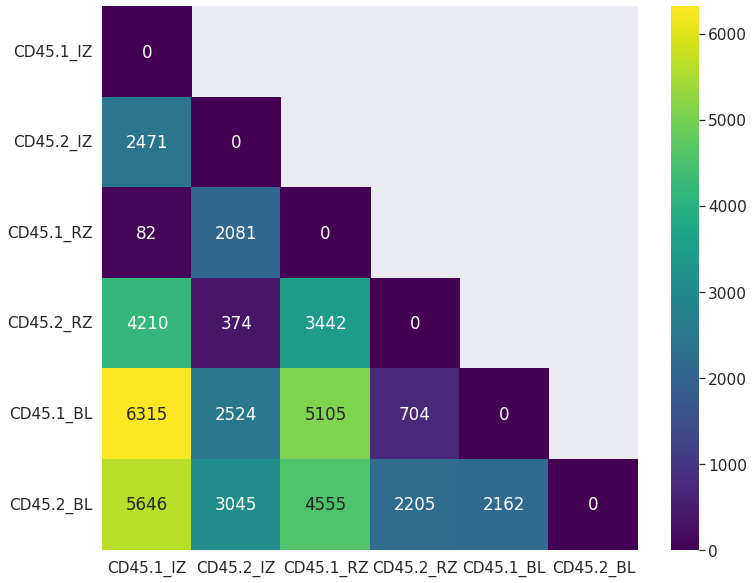

In [8]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
heat_map = sns.heatmap(deMatrix, mask=np.triu(deMatrix, k=1), annot=True, fmt=".0f",xticklabels=conds, yticklabels=conds, cmap="viridis")
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0, va="center")
sns.set()

plt.savefig("all_exp_comparison.png")
plt.savefig("all_exp_comparison.pdf")
plt.savefig("all_exp_comparison.svg")
plt.show()

# Volcano Plots

In [9]:
plotGenes = {}
plotGenes["BL"] = ["Ceacam1", "Chil3", "Ear2", "Ace", "Plac8", "Itgal", "Tmem26", "Spp1", "Cadm1", "Dusp2", "Tln2", "Nr4a1", "Kcnj9", "Xlr", "Ly6c2", "Clec4f", "H2-Ab1", "Cd163", "Cd74", "Stab1", "Gas6", "Mrc1", "Retnla", "Trem2"]
plotGenes["RZ"] = ["Mgl2", "Chil3", "Ephx1", "Thbs1", "Lyve1", "Mmp8", "Timd4", "Ly6c2", "Selenbp1", "Chil4", "Vegfa", "Plac8", "Cxcl3", "Cd163", "Csf3", "Rxra", "Pcdha1", "Retnla", "Ccr2", "Cd74", "Hif1a", "Cd209b", "H2-Aa", "H2-Ab1", "H2-Eb2", "Tgfa"]
plotGenes["IZ"] = ["Timd4", "Sirpb1c", "Ildr2", "Sirpb1a", "S100a4", "Osm", "Cd209f", "Lrg1", "Cd209g", "Retnla", "Lyve1", "Myd88", "Ctsf", "Chil3", "Ccr2", "Cd163", "Ly6c2", "Gas6", "Slamf9", "Timp2", "C1qc", "Stab1", "Hif1a"]

plotGenes["BL"] = ["Kcnj9", "Clec4f", "Zmynd15", "Arap3", "Cadm1", "Tln2", "Sft2d2", "AC132288.1", "Ust", "Gm2539", "Kcnj9", "Map11", "Coro1b", "Rxra", "Ceacam1", "Fgr", "Cytip", "Nfe2", "Gm9733", "Chil3", "Zfyve9", "Ly6i", "Pygl", "Ear2", "Ace"]
#"Igkv12-89","Ighv6-6","Ighv1-55"




In [10]:
keepConds_vp = [
    ("CD45.1_BL", "CD45.2_BL"),
    ("CD45.1_IZ", "CD45.2_IZ"),
    ("CD45.1_RZ", "CD45.2_RZ"),
    
    #("CD45.1_BL", "CD45.1_IZ"),
    #("CD45.1_BL", "CD45.1_RZ"),
    
    #("CD45.2_BL", "CD45.2_IZ"),
    #("CD45.2_BL", "CD45.2_RZ")
]

In [48]:
def plot_volcano(df, genes, title, filefix, colors):
    
    with plt.style.context("default"):
        plt.figure(figsize=(16,10))

        df.sort_values(by=['ROB_ADJ.PVAL'], inplace=True)

        xydots = [(x,y) for x,y in zip(list(df["ROB_log2FC"]), list(-np.log10(df["ROB_ADJ.PVAL"])))]
        maxally = max([x[1] for x in xydots if not np.isinf(x[1])])
        print(maxally)
        xydots = [(x, y if y <= maxally else maxally) for x,y in xydots]

        dotgene = list(df["gene_symbol"])
        texts = []
        seenProts = set()

        sel_down_xy = []
        nosig_down_xy = []

        sel_up_xy = []
        nosig_up_xy = []

        for gi, (x,y) in enumerate(xydots):

            if dotgene[gi] in genes:

                if x < 0:
                    sel_down_xy.append((x,y))
                else:
                    sel_up_xy.append((x,y))


                texts.append(plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[gi], fontsize=18, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)))

            else:

                if x < 0:
                    nosig_down_xy.append((x,y))
                else:
                    nosig_up_xy.append((x,y))

        #print(len(sel_xy), "of", len(genes))

        plt.plot([x[0] for x in nosig_up_xy], [x[1] for x in nosig_up_xy], 'o', color=colors["up"][1])
        plt.plot([x[0] for x in nosig_down_xy], [x[1] for x in nosig_down_xy], 'o', color=colors["down"][1])

        plt.plot([x[0] for x in sel_up_xy], [x[1] for x in sel_up_xy], 'o', color=colors["up"][0])
        plt.plot([x[0] for x in sel_down_xy], [x[1] for x in sel_down_xy], 'o', color=colors["down"][0])


        adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(2, 2), expand_text=(1, 1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
        #        texts.append(plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[gi], fontsize=12))

        plt.title(title, fontsize = 40)
        plt.xlabel("logFC", fontsize = 32)
        plt.ylabel("Neg. Log. Adj. P-Value", fontsize = 32)
        plt.xticks(fontsize=14)


CD45.1_IZ CD45.2_IZ IZ IZ
128.46408323780983


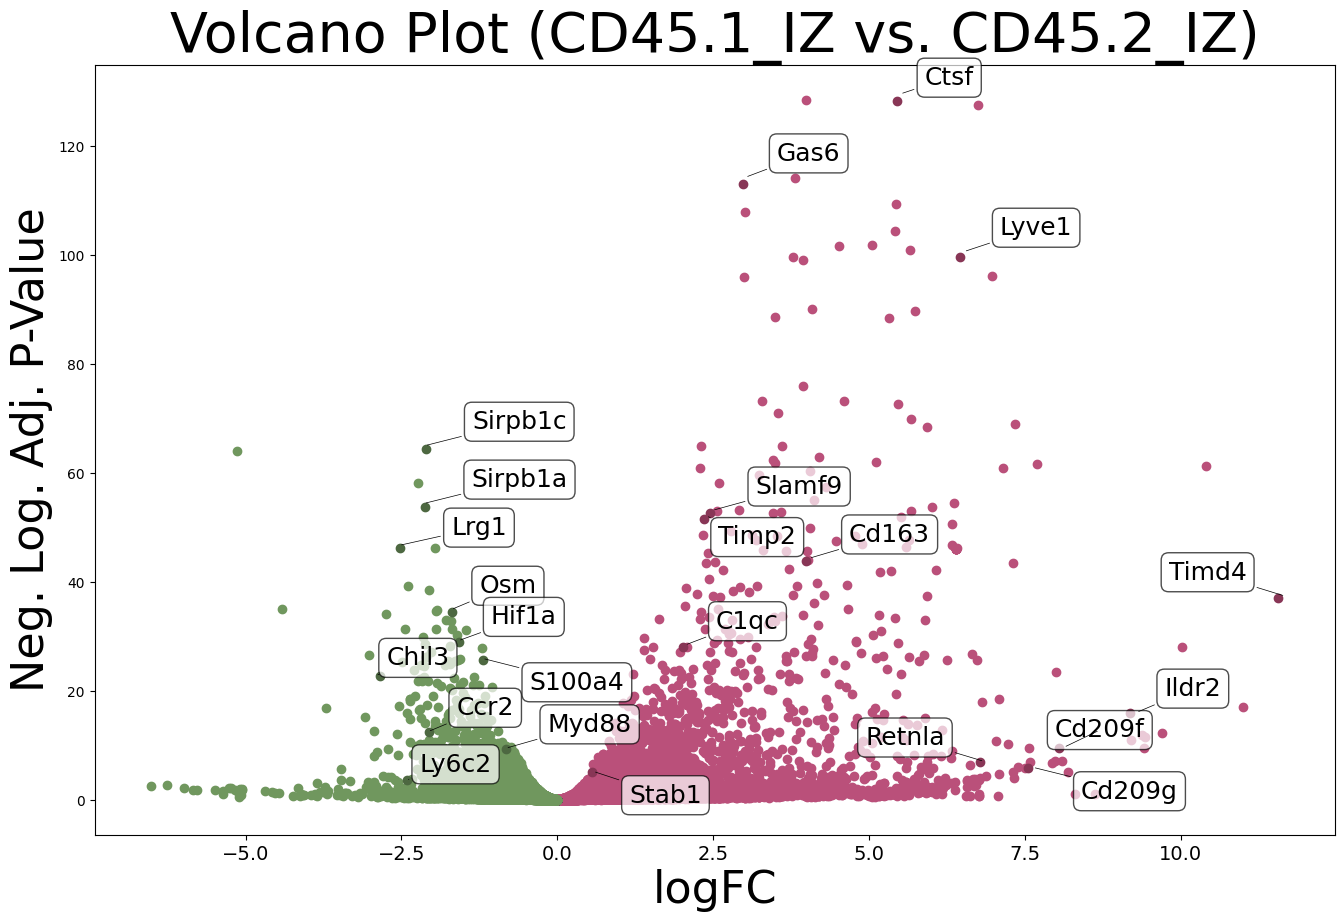

CD45.1_RZ CD45.2_RZ RZ RZ
177.1914889706698


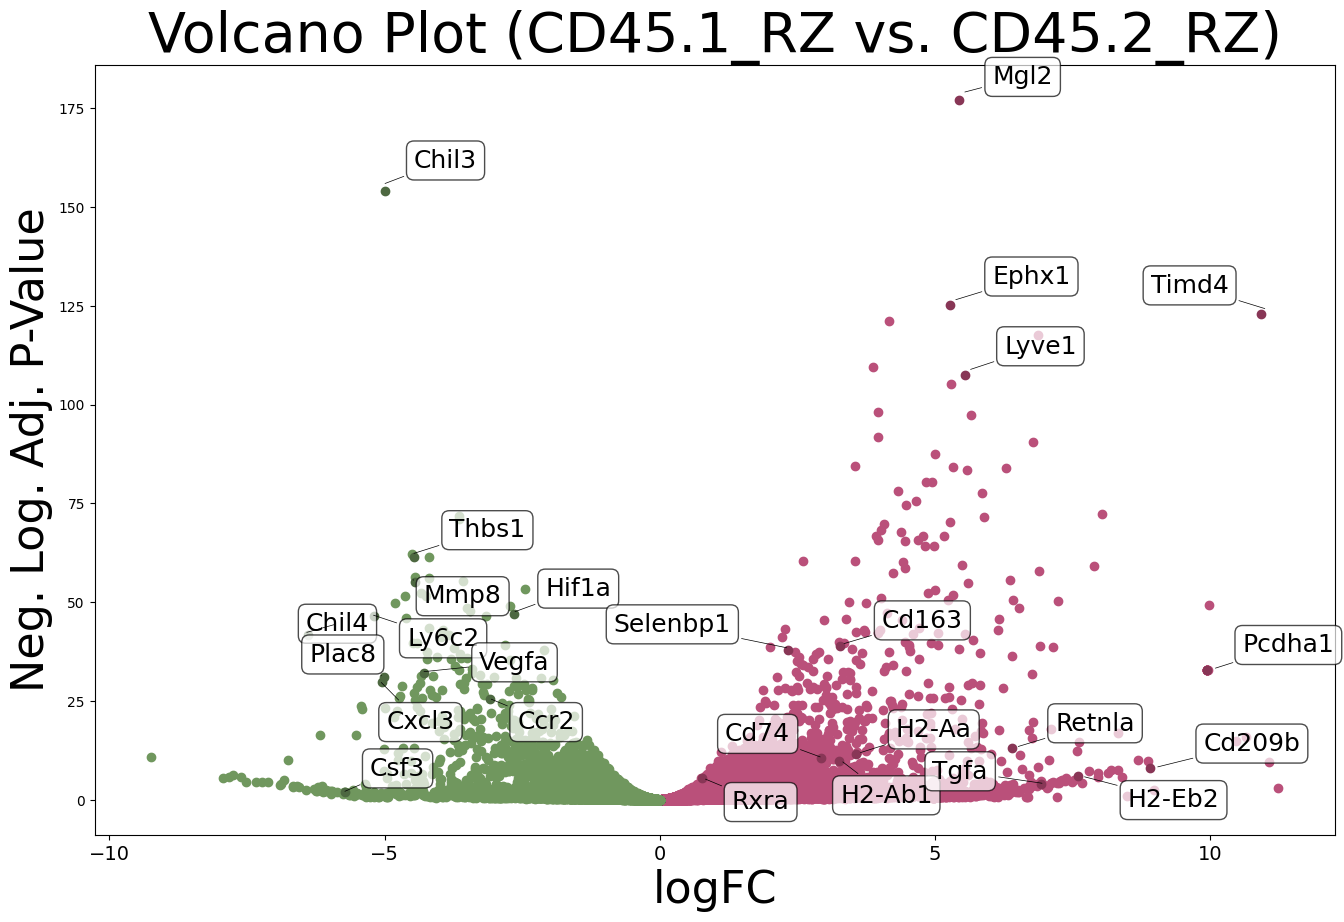

CD45.1_BL CD45.2_BL BL BL
165.14506728849094


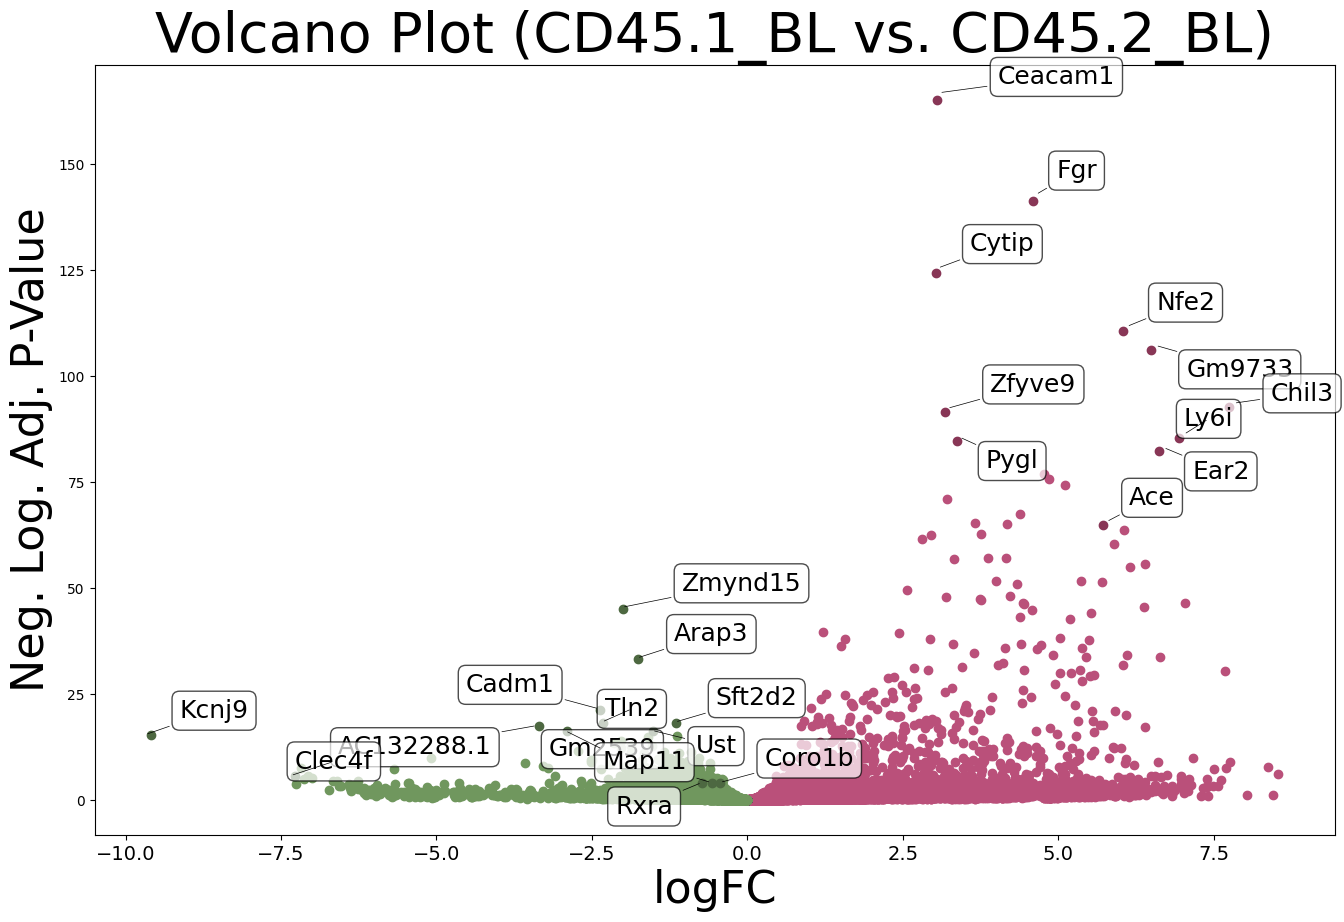

In [49]:

for x in comp2df:
    
    ci,cj = x        
    deDF = comp2df[x]
            
    if (ci, cj) in keepConds_vp:
        direction = (ci, cj)

    elif (cj, ci) in keepConds_vp:
        print(ci, cj, "turn")
        direction = (cj, ci)
        #turn around
        deDF["ROB_log2FC"] = -deDF.ROB_log2FC
    
    else:
        continue
       
    ciEnd = ci[-2:]
    cjEnd = cj[-2:]
    
    ciCond = ci.split("_")
    cjCond = cj.split("_")
    
    print(ci, cj, ciEnd, cjEnd)
    
    deGenes = set(plotGenes[ciEnd]+plotGenes[cjEnd])
    colors = {"up": (color1, color1_nosig), "down": (color2, color2_nosig)}
            
    plot_volcano(deDF, deGenes, "Volcano Plot ({} vs. {})".format(direction[0], direction[1]), filefix="{}_vs_{}".format(direction[0], direction[1]), colors=colors)
        
    plt.savefig("volcano_{}_{}.png".format(ci, cj))
    plt.savefig("volcano_{}_{}.pdf".format(ci, cj))
    plt.savefig("volcano_{}_{}.svg".format(ci, cj))
    
    plt.show()

# ClusterMap

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

rvb = custom_div_cmap(150, mincol=color1,maxcol=color2)
rvb_rev = custom_div_cmap(150, mincol=color2,maxcol=color1)


Text(0.5, 1.0, 'green-gray-blue custom colormap')

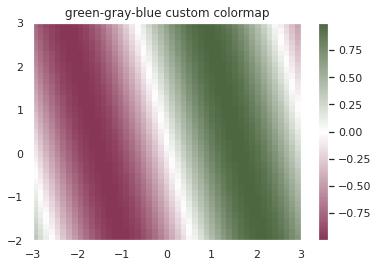

In [14]:
x = np.linspace(-np.pi, np.pi, 50) 
y = np.linspace(-np.pi, np.pi, 50)
X,Y = np.meshgrid(x,y)
Z = np.sin(X + Y/4)

plt.pcolormesh(X, Y, Z, cmap=rvb)
plt.axis([-3, 3, -2, 3])
plt.colorbar()
plt.title('green-gray-blue custom colormap')

In [15]:
def plot_graph(g, base_nodes, node_colors, noDeGenes, title="", outnames=None,figsize=(30,20)):
    plt.figure(figsize=figsize)
    
    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=3.0,
                        strongGravityMode=False,
                        gravity=3.0,

                        # Log
                        verbose=True)

    layout = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)

    vmin = abs(min(node_colors.values()))
    vmax = abs(max(node_colors.values()))
    
    vmax = max([vmin, vmax])
    vmin = -vmax
    
    #cmap = plt.cm.RdBu_r
    cmap = rvb
    
    # 2. Create a layout for our nodes 
    #layout = nx.spring_layout(g,k=0.5, iterations=50, weight='weight', center=(0.5, 0.5))

    # 3. Draw the parts we want
    nx.draw_networkx_edges(g, layout, edge_color='#AAAAAA')

    baseNodes = [node for node in g.nodes() if node in base_nodes]
    size = [g.degree(node) * 80 for node in g.nodes() if node in base_nodes]
    nodeColors = []
    for node in baseNodes:
        nodeColors.append( node_colors[node] )
        
        
    nx.draw_networkx_nodes(g, layout, nodelist=baseNodes, node_size=size, node_color=nodeColors, cmap=cmap, vmin=vmin, vmax=vmax)

    satelliteNodes = [node for node in g.nodes() if not node in base_nodes and not node in noDeGenes]
    
    nodeColors = []
    for node in satelliteNodes:
        nodeColors.append( node_colors[node] )
        
    size = [g.degree(node) * 100 for node in satelliteNodes]
    nx.draw_networkx_nodes(g, layout, nodelist=satelliteNodes, node_size=size, node_color=nodeColors, cmap=cmap, vmin=vmin, vmax=vmax)                    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    
    
    addNodes = [node for node in g.nodes() if node in noDeGenes]
    nx.draw_networkx_nodes(g, layout, nodelist=addNodes, node_color="grey")
    
    texts = []
    
    for node in layout:
        
        x,y = layout[node]
        texts.append(plt.text(x * (1 + 0.01), y * (1 + 0.01) , node, fontsize=12))
    
    adjust_text(texts, force_points=0.5, force_text=0.5, va="bottom", ha="left", arrowprops=dict(arrowstyle="-", color='red', lw=0.25))
#        texts.append(plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[gi], fontsize=12))
    
    #club_dict = dict(zip(clubs, clubs))
    #nx.draw_networkx_labels(g, layout, labels=club_dict)

    #bulk_dict = dict(zip(people, people))
    #nx.draw_networkx_labels(g, layout, labels=bulk_dict)

    # 4. Turn off the axis because I know you don't want it
    plt.axis('off')
    plt.title(title)
    
    if outnames != None:
        for outname in outnames:
            plt.gcf().savefig(outname, bbox_inches='tight')
    
    # 5. Tell matplotlib to show it
    plt.show()

In [16]:
keepConds_cm = [
    ("CD45.1_BL", "CD45.2_BL"),
    ("CD45.1_IZ", "CD45.2_IZ"),
    ("CD45.1_RZ", "CD45.2_RZ"),
    
    #("CD45.1_BL", "CD45.1_IZ"),
    #("CD45.1_BL", "CD45.1_RZ"),
    
    #("CD45.2_BL", "CD45.2_IZ"),
    #("CD45.2_BL", "CD45.2_RZ")
]

In [17]:
def plot_go_terms(topGOs, deDF,go2nes, addNonDE = False, res_prefix="go_clustermap", figsize=(30,20)):
    
    print(topGOs)
    g = nx.Graph()
    goDEGeneDFs = []
    
    for goID, goName in topGOs:
        
        topGoGenes = get_genes_from_term(go, go2genes, goID)
        goDEGenes = deDF[deDF.gene_symbol.isin(topGoGenes)]
        goDEGenes = goDEGenes.loc[:,["gene_symbol", "ROB_log2FC","ROB_ADJ.PVAL" ]]
        
        print(goID, goName, goDEGenes.shape)
        
        goDEGeneDFs.append(goDEGenes)
        
    goDEGeneDF = pd.concat(goDEGeneDFs)
    goDEGeneDF = goDEGeneDF[goDEGeneDF["ROB_ADJ.PVAL"] < 0.05]
    goDEGeneDF = goDEGeneDF[abs(goDEGeneDF["ROB_log2FC"]) > 1]
    
    deSyms = set()
    noDeGenes = set()
    
    for goID, goName in topGOs:
        
        topGoGenes = go2genes[goID]
        goDEGenes = goDEGeneDF[goDEGeneDF.gene_symbol.isin(topGoGenes)]

        for geneidx, gene in goDEGenes.iterrows():
            gsym = gene["gene_symbol"]
            gfc = gene["ROB_log2FC"]
            gpval = gene["ROB_ADJ.PVAL"]
            
            g.add_edge(gsym, goName)
            g.nodes[gsym]["fc"] = gfc
            
            deSyms.add(gsym)
            if gsym in noDeGenes:
                noDeGenes.remove(gsym)
            
        for gene in topGoGenes:
            
            if not addNonDE:
                continue

            if gene in deSyms:
                continue
                
            noDeGenes.add(gene)
                
            g.add_edge(gene, goName)
            g.nodes[gene]["fc"] = 10
            
    baseSamples = []
    node2color = {}
    for node in g.nodes():
        
        if not "fc" in g.nodes[node]:
            baseSamples.append(node)
            node2color[node] = go2nes.get(node, 0)
        elif "fc" in g.nodes[node] and not node in noDeGenes:
            node2color[node] = g.nodes[node]["fc"]
        
        
    outnames = []
    for ext in ["png", "pdf", "svg"]:
        outnames.append("{}.{}_{}.{}".format(res_prefix, ci,cj, ext))
    
    print("Gfap" in baseSamples)
    print("Gfap" in node2color)
    print("Gfap" in deSyms)
    print("Gfap" in noDeGenes)
    
    plot_graph(g,baseSamples,node2color, noDeGenes, title="{} vs {}".format(ci,cj), outnames=outnames)

In [18]:
conds_cm = ["CD45.1_IZ","CD45.2_IZ","CD45.1_RZ","CD45.2_RZ","CD45.1_BL","CD45.2_BL"]

go2df = {}

for i in range(0, len(conds_cm)):
    for j in range(i+1, len(conds_cm)):
        
        ci = conds_cm[i]
        cj = conds_cm[j]
        
        reportsFile = "../reports_merged/{}_vs_{}/{}_vs_{}.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv".format(ci,cj, ci,cj)
        print(reportsFile, os.path.isfile(reportsFile))
        
        godf = pd.read_csv(reportsFile, sep="\t")
        godf["comp"] = "{}_vs_{}".format(ci,cj)
            
        
        godf = godf[godf.qvalue < 0.1]       
        go2df[(ci, cj)] = godf
        print(ci, cj)


../reports_merged/CD45.1_IZ_vs_CD45.2_IZ/CD45.1_IZ_vs_CD45.2_IZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv True
CD45.1_IZ CD45.2_IZ
../reports_merged/CD45.1_IZ_vs_CD45.1_RZ/CD45.1_IZ_vs_CD45.1_RZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv True
CD45.1_IZ CD45.1_RZ
../reports_merged/CD45.1_IZ_vs_CD45.2_RZ/CD45.1_IZ_vs_CD45.2_RZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv True
CD45.1_IZ CD45.2_RZ
../reports_merged/CD45.1_IZ_vs_CD45.1_BL/CD45.1_IZ_vs_CD45.1_BL.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv True
CD45.1_IZ CD45.1_BL
../reports_merged/CD45.1_IZ_vs_CD45.2_BL/CD45.1_IZ_vs_CD45.2_BL.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv True
CD45.1_IZ CD45.2_BL
../reports_merged/CD45.2_IZ_vs_CD45.1_RZ/CD45.2_IZ_vs_CD45.1_RZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv True
CD45.2_IZ CD45.1_RZ
../reports_merged/CD45.2_IZ_vs_CD45.2_RZ/CD45.2_IZ_vs_CD45.2_RZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv True
CD45.2_IZ CD45.2_RZ
../rep

In [19]:
#! wget http://ftp.ebi.ac.uk//pub/databases/GO/goa/MOUSE/goa_mouse.gaf.gz
#! wget 'http://purl.obolibrary.org/obo/go/go-basic.obo'

In [20]:
goa_mouse = "goa_mouse.gaf.gz"

# File is a gunzip file, so we need to open it in this way
with gzip.open(goa_mouse, 'rt') as arab_gaf_fp:
    mouse_funcs = {}  # Initialise the dictionary of functions
    go2genes = defaultdict(set)
    go2name = {}
    # Iterate on each function using Bio.UniProt.GOA library.
    for entry in GOA.gafiterator(arab_gaf_fp):
        uniprot_id = entry.pop('DB_Object_Symbol')
        mouse_funcs[uniprot_id] = entry
        go2genes[entry["GO_ID"]].add(uniprot_id)

        
go = obo_parser.GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2020-12-08) 47,295 GO Terms


In [21]:
def get_genes_from_term( go, go2genes, termid ):
    all_children = go[termid].get_all_children()
    all_genes = go2genes[termid]
    
    for term in all_children:
        all_term_genes = go2genes[term]
        all_genes = all_genes.union(all_term_genes)
        
    return all_genes

('CD45.1_IZ', 'CD45.2_IZ')
[('GO:0051928', 'GO:0051928\npositive regulation of calcium ion transport'), ('GO:0007423', 'GO:0007423\nsensory organ development'), ('GO:0043270', 'GO:0043270\npositive regulation of ion transport'), ('GO:0043062', 'GO:0043062\nextracellular structure organization'), ('GO:0030198', 'GO:0030198\nextracellular matrix organization'), ('GO:0043269', 'GO:0043269\nregulation of ion transport'), ('GO:1904427', 'GO:1904427\npositive regulation of calcium ion transmembrane transport'), ('GO:0034767', 'GO:0034767\npositive regulation of ion transmembrane transport'), ('GO:1904064', 'GO:1904064\npositive regulation of cation transmembrane transport'), ('GO:0060537', 'GO:0060537\nmuscle tissue development'), ('GO:0048738', 'GO:0048738\ncardiac muscle tissue development')]
GO:0051928 GO:0051928
positive regulation of calcium ion transport (145, 3)
GO:0007423 GO:0007423
sensory organ development (176, 3)
GO:0043270 GO:0043270
positive regulation of ion transport (733, 3)

  0%|          | 0/2000 [00:00<?, ?it/s]

False
False
False
False


100%|██████████| 2000/2000 [00:00<00:00, 5137.43it/s]


BarnesHut Approximation  took  0.10  seconds
Repulsion forces  took  0.18  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


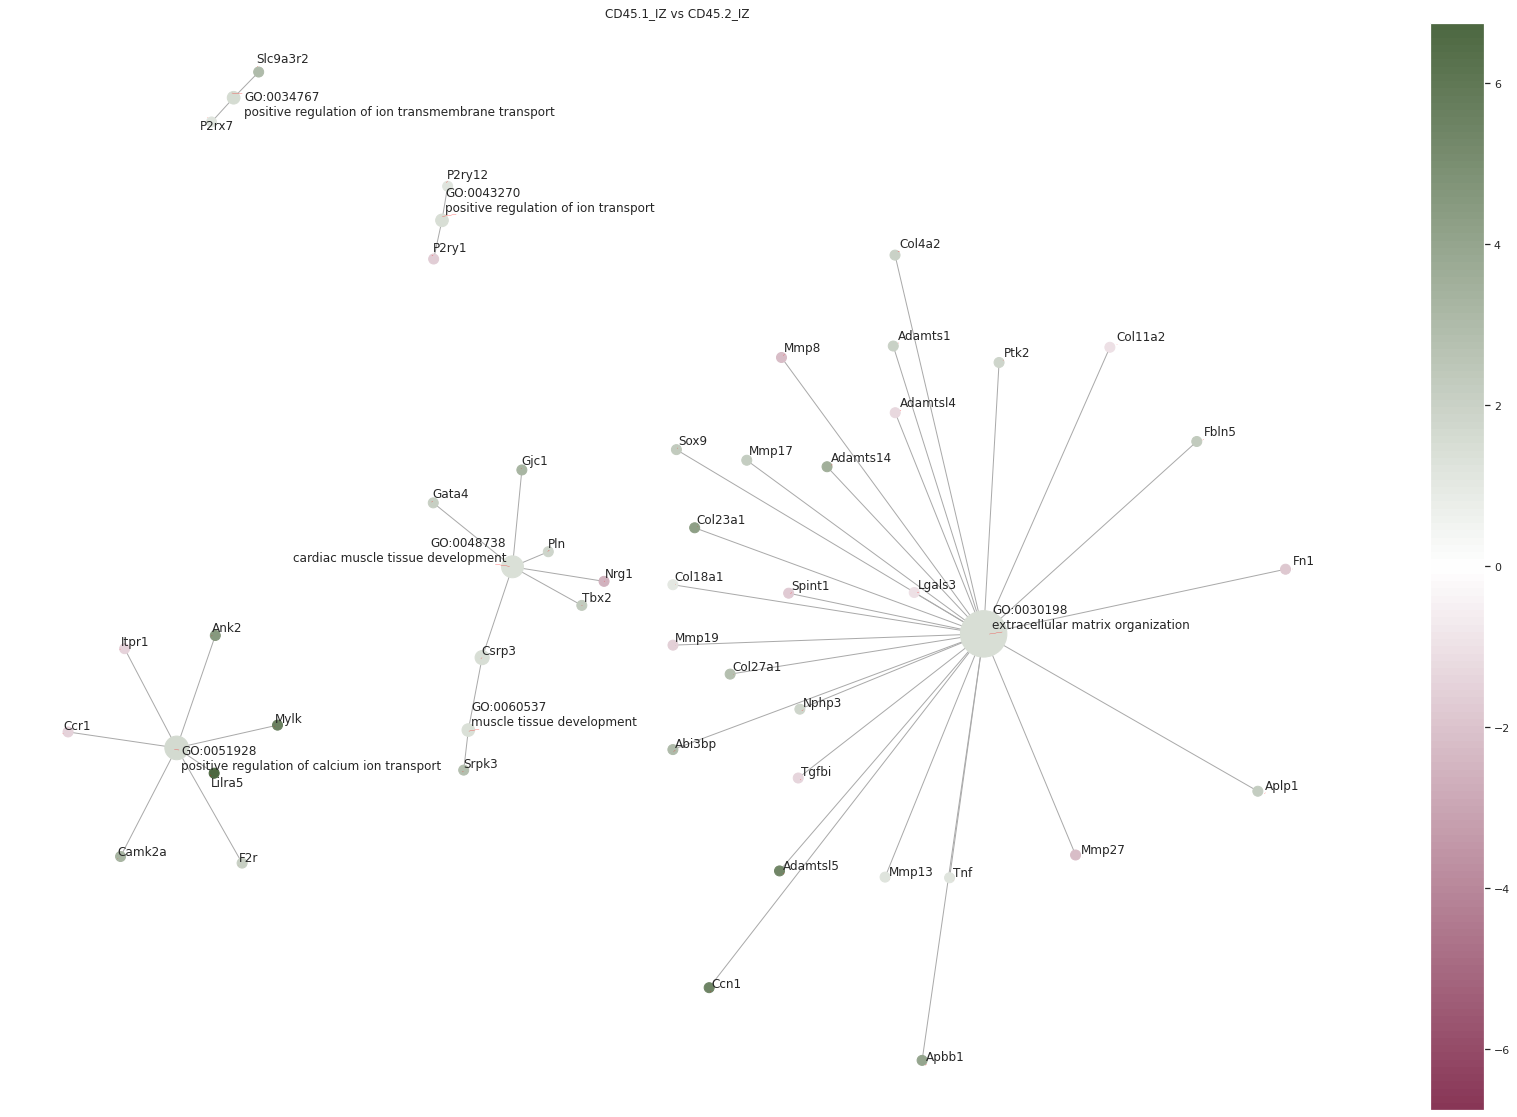

  0%|          | 0/2000 [00:00<?, ?it/s]

('CD45.1_RZ', 'CD45.2_RZ')
[('GO:0032496', 'GO:0032496\nresponse to lipopolysaccharide'), ('GO:0007423', 'GO:0007423\nsensory organ development'), ('GO:0048645', 'GO:0048645\nanimal organ formation'), ('GO:0007600', 'GO:0007600\nsensory perception'), ('GO:0043062', 'GO:0043062\nextracellular structure organization'), ('GO:0030198', 'GO:0030198\nextracellular matrix organization'), ('GO:0060421', 'GO:0060421\npositive regulation of heart growth'), ('GO:0044057', 'GO:0044057\nregulation of system process'), ('GO:0002446', 'GO:0002446\nneutrophil mediated immunity'), ('GO:0007389', 'GO:0007389\npattern specification process'), ('GO:0046622', 'GO:0046622\npositive regulation of organ growth')]
GO:0032496 GO:0032496
response to lipopolysaccharide (326, 3)
GO:0007423 GO:0007423
sensory organ development (176, 3)
GO:0048645 GO:0048645
animal organ formation (21, 3)
GO:0007600 GO:0007600
sensory perception (1540, 3)
GO:0043062 GO:0043062
extracellular structure organization (264, 3)
GO:0030198

100%|██████████| 2000/2000 [00:00<00:00, 2511.21it/s]


BarnesHut Approximation  took  0.18  seconds
Repulsion forces  took  0.45  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


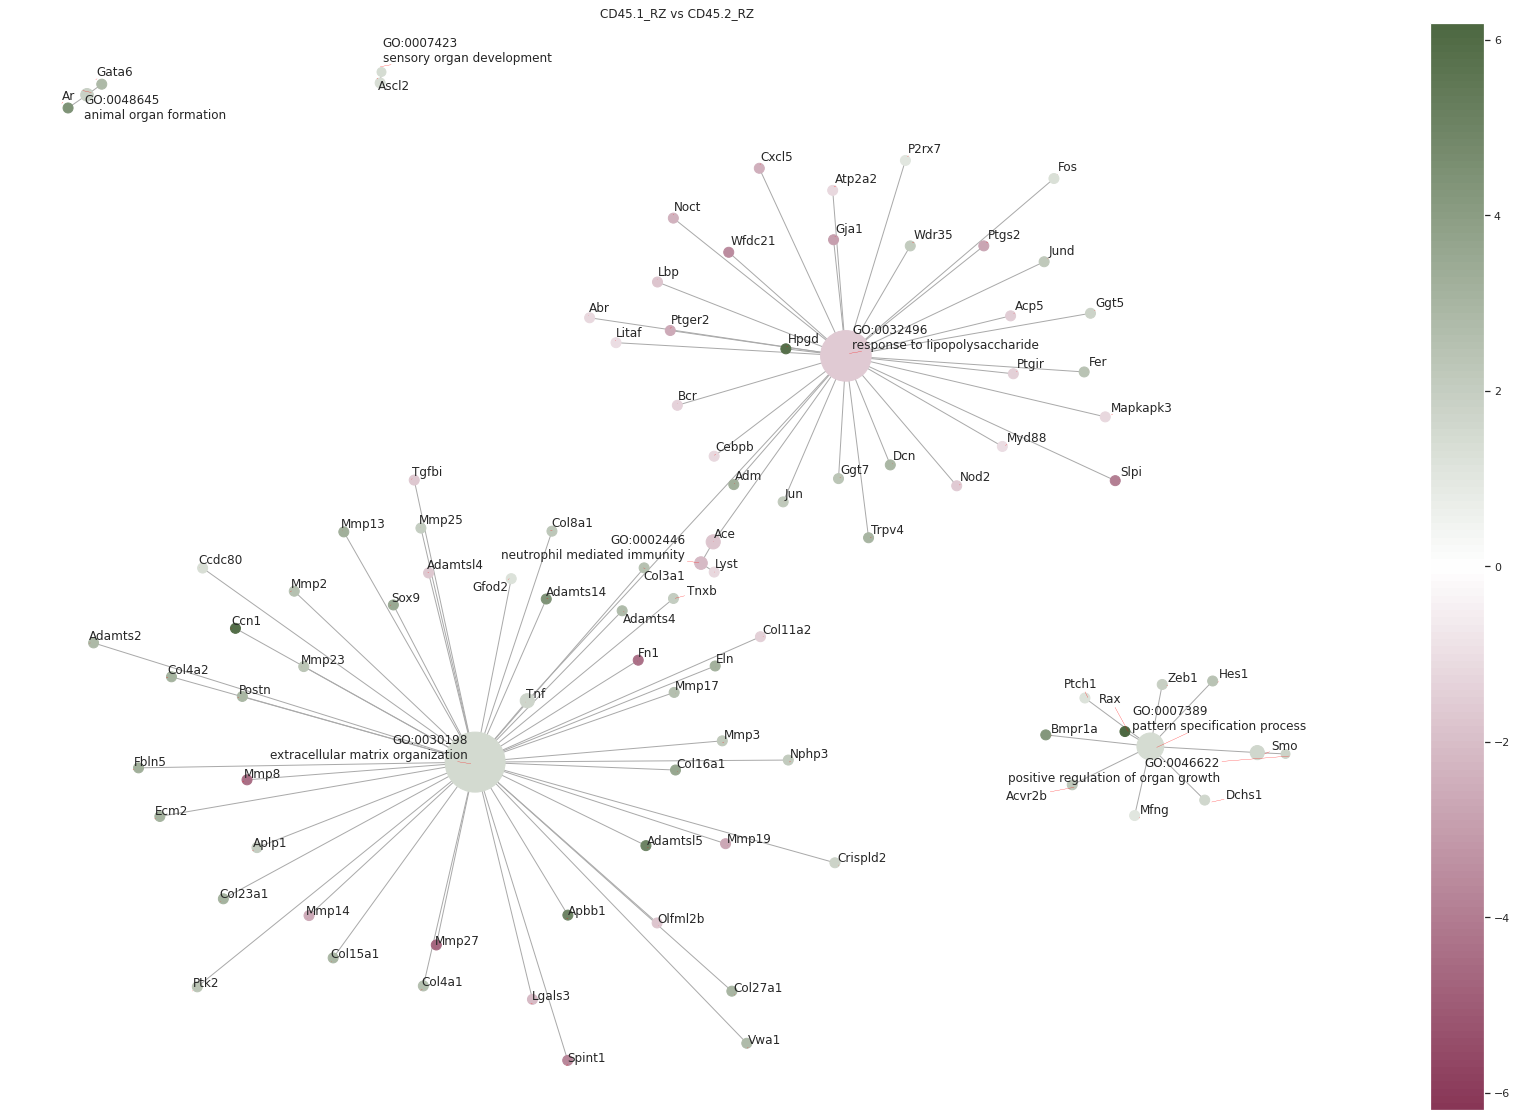

('CD45.1_BL', 'CD45.2_BL')
[('GO:0002250', 'GO:0002250\nadaptive immune response'), ('GO:0002683', 'GO:0002683\nnegative regulation of immune system process'), ('GO:0002694', 'GO:0002694\nregulation of leukocyte activation'), ('GO:0007159', 'GO:0007159\nleukocyte cell-cell adhesion'), ('GO:0022407', 'GO:0022407\nregulation of cell-cell adhesion'), ('GO:0042110', 'GO:0042110\nT cell activation'), ('GO:0050863', 'GO:0050863\nregulation of T cell activation'), ('GO:0051249', 'GO:0051249\nregulation of lymphocyte activation'), ('GO:1903037', 'GO:1903037\nregulation of leukocyte cell-cell adhesion'), ('GO:0002521', 'GO:0002521\nleukocyte differentiation'), ('GO:0045785', 'GO:0045785\npositive regulation of cell adhesion')]
GO:0002250 GO:0002250
adaptive immune response (214, 3)
GO:0002683 GO:0002683
negative regulation of immune system process (409, 3)
GO:0002694 GO:0002694
regulation of leukocyte activation (663, 3)
GO:0007159 GO:0007159
leukocyte cell-cell adhesion (58, 3)
GO:0022407 GO:0

 11%|█         | 222/2000 [00:00<00:00, 2215.40it/s]

False
False
False
False


100%|██████████| 2000/2000 [00:00<00:00, 2350.53it/s]


BarnesHut Approximation  took  0.19  seconds
Repulsion forces  took  0.47  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


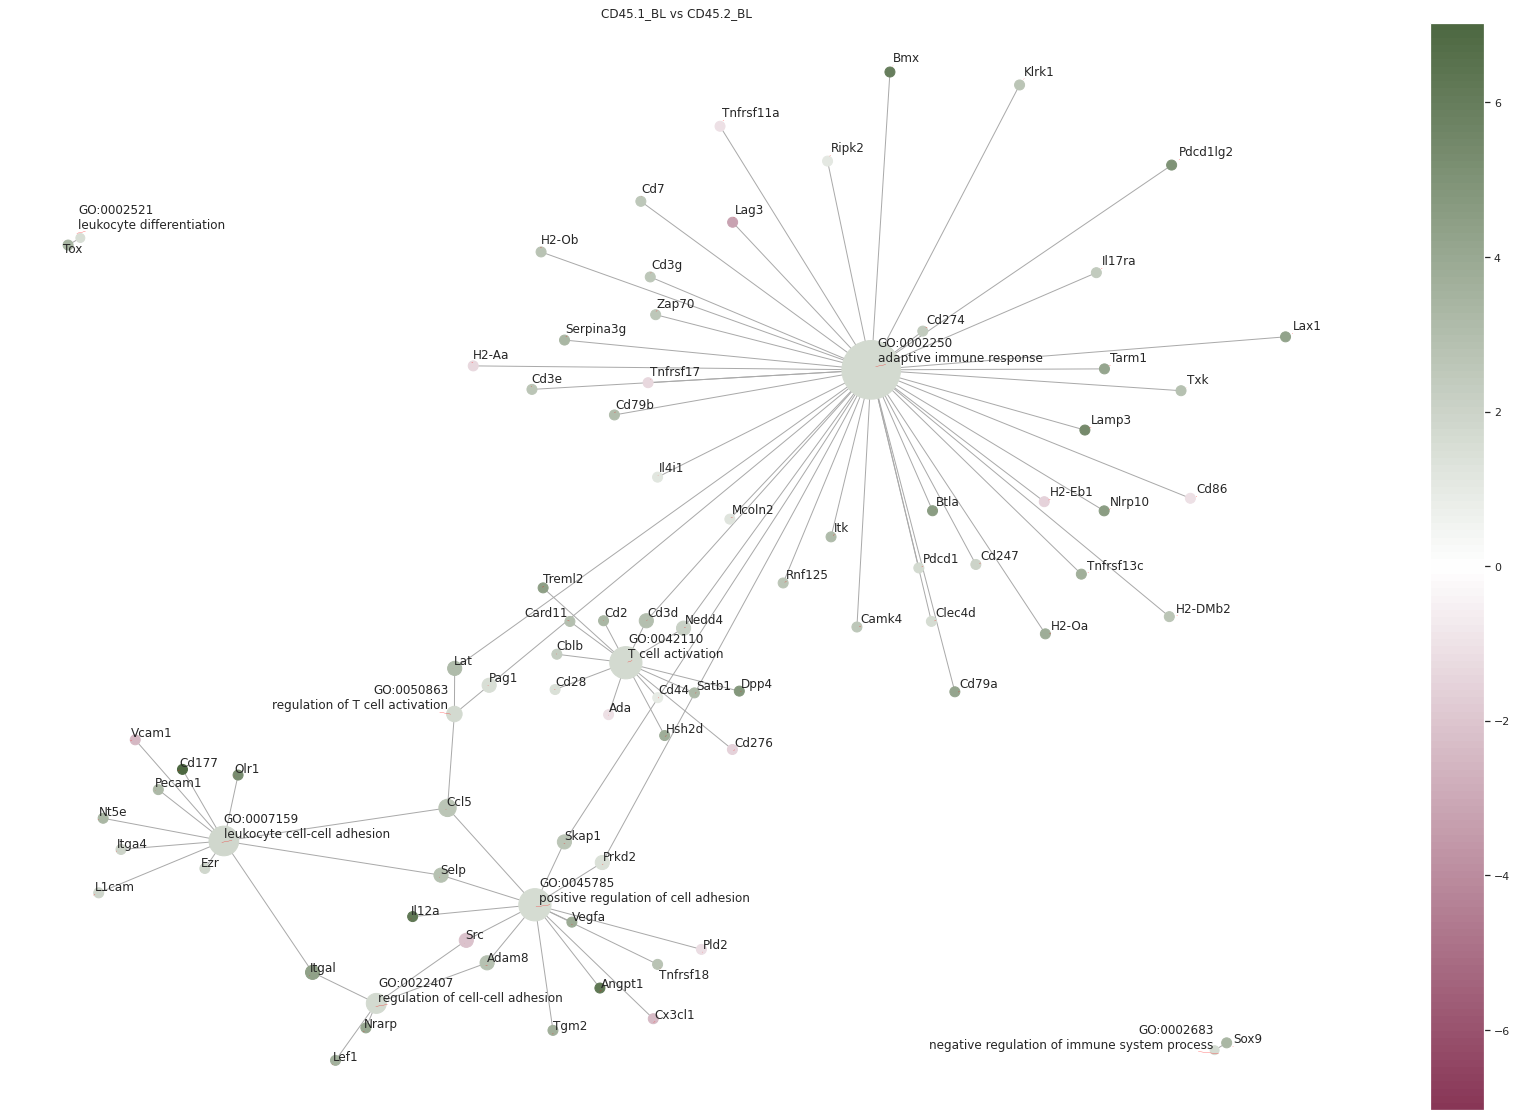

In [22]:
for x in comp2df:
    
    ci,cj = x
    
    if not x in go2df:
        continue
        
    goDF = go2df[x]
    deDF = comp2df[x]
            
    if (ci, cj) in keepConds_cm:

        pass

    elif (cj, ci) in keepConds_cm:
        print(ci, cj, "turn")
        #turn around

        godf["NES"] = -godf.NES
        deDF["ROB_log2FC"] = -deDF.ROB_log2FC
    
    else:
        continue
        
    print(x)
    
    goDF = goDF.sort_values(by='qvalue')
    goDF["GONAME"] = goDF["GO.ID"] + "\n" + goDF["Description"]
    
    go2nes = {}
    
    topGOs = []
    for row_index,row in goDF.iterrows():
        goID = (row["GO.ID"], row["GONAME"])
        go2nes[goID[1]] = row["NES"]
        
        if "rRNA" in goID[1] or "ribosom" in goID[1]:
            continue
        
        topGOs.append(goID)
        
        if len(topGOs) > 10:
            break
        
    plot_go_terms(topGOs, deDF,go2nes, res_prefix="cluster_map")
        


# GO Comparison

In [23]:
! ls ../reports_merged/*vs*/*.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv

../reports_merged/CD45.1_BL_vs_CD45.2_BL/CD45.1_BL_vs_CD45.2_BL.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_IZ_vs_CD45.1_BL/CD45.1_IZ_vs_CD45.1_BL.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_IZ_vs_CD45.1_RZ/CD45.1_IZ_vs_CD45.1_RZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_IZ_vs_CD45.2_BL/CD45.1_IZ_vs_CD45.2_BL.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_IZ_vs_CD45.2_IZ/CD45.1_IZ_vs_CD45.2_IZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_IZ_vs_CD45.2_RZ/CD45.1_IZ_vs_CD45.2_RZ.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_RZ_vs_CD45.1_BL/CD45.1_RZ_vs_CD45.1_BL.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_RZ_vs_CD45.2_BL/CD45.1_RZ_vs_CD45.2_BL.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv
../reports_merged/CD45.1_RZ_vs_CD45.2_RZ/CD45.1_RZ_vs_CD45.2_RZ.

In [24]:
keepConds_goc = [
    ("CD45.1_BL", "CD45.2_BL"),
    ("CD45.1_IZ", "CD45.2_IZ"),
    ("CD45.1_RZ", "CD45.2_RZ"),
    
    ("CD45.1_BL", "CD45.1_IZ"),
    ("CD45.1_BL", "CD45.1_RZ"),
    
    ("CD45.2_BL", "CD45.2_IZ"),
    ("CD45.2_BL", "CD45.2_RZ")
]

In [25]:
conds = ["CD45.1_IZ","CD45.2_IZ","CD45.1_RZ","CD45.2_RZ","CD45.1_BL","CD45.2_BL"]

go2df_goc = {}

for i in range(0, len(conds)):
    for j in range(i+1, len(conds)):
        
        ci = conds[i]
        cj = conds[j]
        
        reportsFile = "../reports_merged/{}_vs_{}/{}_vs_{}.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv".format(ci,cj, ci,cj)
        
        godf = pd.read_csv(reportsFile, sep="\t")
        
        if (ci, cj) in keepConds_goc:
            
            godf["comp"] = "{}_vs_{}".format(ci,cj)
            
        elif (cj, ci) in keepConds_goc:
            print(ci, cj, "turn")
            #turn around
            godf["comp"] = "{}_vs_{}".format(cj,ci)
            godf["NES"] = -godf.NES
            
        else:
            continue
            
        
        godf = godf[godf.qvalue < 0.1]
        #godf["NES"] = -godf.NES
        
        go2df_goc[(cj, ci)] = godf
        print(ci, cj)
        
        
        
        #print(ci, cj, reportsFile, os.path.exists(reportsFile), go2df[(ci,cj)].shape)

all_go = pd.concat(go2df_goc.values())
all_go["GO_SIZE"] = all_go.core_enrichment.str.split("/").map(len)
all_go['GO_DS'] = all_go[["GO.ID", "Description"]].agg(': '.join, axis=1)

sel_go = all_go.loc[:,['comp', 'GO_DS', 'GO_SIZE', 'NES', 'qvalue']]
sel_go

topGONames = sel_go.GO_DS.value_counts()[:60].index.tolist()

top_go = sel_go[sel_go.GO_DS.isin(topGONames)]

#tiGO =top_go.set_index(["comp", "Description"])
tiGO = top_go.loc[:, ['comp', 'GO_DS', 'NES', 'GO_SIZE']]
tiGO             

CD45.1_IZ CD45.2_IZ
CD45.1_IZ CD45.1_BL turn
CD45.1_IZ CD45.1_BL
CD45.2_IZ CD45.2_BL turn
CD45.2_IZ CD45.2_BL
CD45.1_RZ CD45.2_RZ
CD45.1_RZ CD45.1_BL turn
CD45.1_RZ CD45.1_BL
CD45.2_RZ CD45.2_BL turn
CD45.2_RZ CD45.2_BL
CD45.1_BL CD45.2_BL


,comp,GO_DS,NES,GO_SIZE
0,CD45.1_IZ_vs_CD45.2_IZ,GO:0042273: ribosomal large subunit biogenesis,-2.535994,62
1,CD45.1_IZ_vs_CD45.2_IZ,GO:0051928: positive regulation of calcium ion...,1.635401,43
3,CD45.1_IZ_vs_CD45.2_IZ,GO:0043270: positive regulation of ion transport,1.470565,86
4,CD45.1_IZ_vs_CD45.2_IZ,GO:0043062: extracellular structure organization,1.454912,108
5,CD45.1_IZ_vs_CD45.2_IZ,GO:0030198: extracellular matrix organization,1.452813,107
...,...,...,...,...
295,CD45.1_BL_vs_CD45.2_BL,GO:0046633: alpha-beta T cell proliferation,1.588173,19
303,CD45.1_BL_vs_CD45.2_BL,GO:0043029: T cell homeostasis,1.605709,16
307,CD45.1_BL_vs_CD45.2_BL,GO:0043368: positive T cell selection,1.566884,10
323,CD45.1_BL_vs_CD45.2_BL,GO:0002446: neutrophil mediated immunity,1.620044,8


In [26]:
def plotORAresult( df_raw, title, numResults=10, filename=None, less=None, more=None):
    #https://www.programmersought.com/article/8628812000/
    
    def makeTitle(col1, col2):
        out = []
        for x ,y in zip(col1, col2):
            ax = x.split(": ")
            out.append("{} ({}, n={})".format(ax[1], ax[0], y))

        return out


    df_raw['termtitle'] = makeTitle(df_raw["GO_DS"], df_raw["GO_SIZE"])

    # Prepare Data
    #df = df_raw[['cty', 'manufacturer']].groupby('manufacturer').apply(lambda x: x.mean())
    df = pd.DataFrame(df_raw)
    df = df[["termtitle", "qvalue", "NES", "GO_SIZE"]]
    df.sort_values('qvalue', inplace=True, ascending=True)
    df.reset_index()
    df = df[:numResults]
    
    df = df.iloc[::-1]
    
    maxNLog = max(-np.log(df.qvalue))
    maxLine = ((maxNLog// 10)+1)*10
    #print(maxNLog, maxLine)
    
    
    # Draw plot
    fig, ax = plt.subplots(figsize=(10,10), dpi= 80)
    ax.hlines(y=df.termtitle, xmin=0, xmax=maxLine, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
    ax.vlines(x=-np.log(0.05), ymin=0, ymax=numResults, color='red', alpha=0.7, linewidth=1, linestyles='dashdot')
    
    maxNES = max(df.NES.max(), -df.NES.min())
    print(maxNES)
    nesValues = (1.0+(-df.NES / maxNES)) / 2.0
    colorValues = [rvb(x) for x in nesValues]
    
    sizeFactor = 10    
    scatter = ax.scatter(y=df.termtitle, x=-np.log(df.qvalue), s=df.GO_SIZE*sizeFactor, c=colorValues, alpha=0.7, )

    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, func=lambda x: x/sizeFactor)
    labels = [x for x in labels]
    #legend2 = ax.legend(handles, labels, loc="upper left", title="Sizes")


    # Title, Label, Ticks and Ylim
    ax.set_title(title, fontdict={'size':12})
    ax.set_xlabel('Neg. Log. Adj. p-Value')
    ax.set_yticks(df.termtitle)
    ax.set_yticklabels(df.termtitle, fontdict={'horizontalalignment': 'right'})
    plt.grid(b=None)
    plt.tight_layout()
    
    if filename != None:
        for x in filename:
            plt.savefig(x)
    
    plt.show()

In [27]:
rvb(1.0)

(0.30196078431372547, 0.40784313725490196, 0.2549019607843137, 1.0)

In [28]:
sortPlotDF = sel_go[sel_go.comp=="CD45.1_BL_vs_CD45.2_BL"].sort_values("NES")
#sortPlotDF = sortPlotDF.loc[[x for x in range(0,15,1)]+[x for x in range(len(sortPlotDF)-15,len(sortPlotDF))],]
sortPlotDF

,comp,GO_DS,GO_SIZE,NES,qvalue
199,CD45.1_BL_vs_CD45.2_BL,GO:1902285: semaphorin-plexin signaling pathwa...,10,-1.794042,2.840694e-02
255,CD45.1_BL_vs_CD45.2_BL,GO:0090382: phagosome maturation,12,-1.792621,4.435642e-02
281,CD45.1_BL_vs_CD45.2_BL,GO:1902287: semaphorin-plexin signaling pathwa...,9,-1.759769,5.060194e-02
382,CD45.1_BL_vs_CD45.2_BL,GO:0072697: protein localization to cell cortex,3,-1.678648,9.372364e-02
276,CD45.1_BL_vs_CD45.2_BL,GO:0070848: response to growth factor,105,1.296219,5.001804e-02
...,...,...,...,...,...
89,CD45.1_BL_vs_CD45.2_BL,GO:0002837: regulation of immune response to t...,12,1.796404,3.730663e-03
95,CD45.1_BL_vs_CD45.2_BL,GO:0002418: immune response to tumor cell,13,1.797820,4.399742e-03
16,CD45.1_BL_vs_CD45.2_BL,GO:0010466: negative regulation of peptidase a...,48,1.808915,1.107937e-05
24,CD45.1_BL_vs_CD45.2_BL,GO:0032609: interferon-gamma production,51,1.835489,3.052752e-05


1.83853995713128


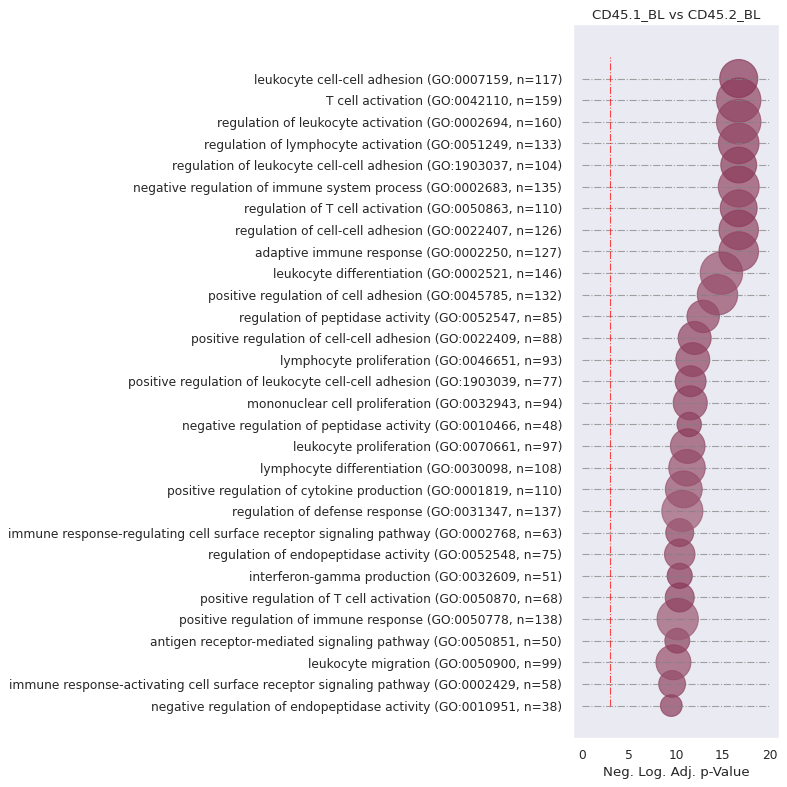

In [29]:
oraDF = sortPlotDF.copy()
plotORAresult(oraDF, "CD45.1_BL vs CD45.2_BL", numResults=30, filename=["bl_cd45_comparison.png", "bl_cd45_comparison.pdf", "bl_cd45_comparison.svg"])

In [30]:
#plotDF = tiGO[tiGO.comp.isin(["CD45.1_IZ_vs_CD45.2_IZ","CD45.1_RZ_vs_CD45.2_RZ"])]
plotDF = tiGO[tiGO.comp !="CD45.1_BL_vs_CD45.2_BL"]

plotDF = plotDF.pivot("comp", "GO_DS", "NES").transpose()
plotDF = plotDF.fillna(0)

idxElem2GoInfo = {}

for elem in plotDF.index:
    es = elem.split(":")
    goIdIdx = ":".join(es[:2])
    print(goIdIdx)
    
    gosubdag = GoSubDag(goIdIdx, go, prt=False)
    
    level2info = {}
    for p_go in gosubdag.rcntobj.go2ancestors[goIdIdx]:
        idInfo = gosubdag.go2nt[p_go]._asdict()        
        level2info[idInfo["level"]] = idInfo
        
    goLevel = 1
    if goLevel in level2info:
        useElem = level2info[goLevel]
    else:
        print("no level for", elem, level2info)
        goDesc = elem.split(": ")[1]
        useElem = {'GO': goIdIdx, 'GO_name': goDesc}
    idxElem2GoInfo[goIdIdx] = useElem
    

allParents = set()
for x in idxElem2GoInfo:
    allParents.add(idxElem2GoInfo[x]["GO"])
    
allParents = list(allParents)
allColors = sns.color_palette("Set2", len(allParents))
indexColors = []

for elem in plotDF.index:
    es = elem.split(":")
    goIdIdx = ":".join(es[:2])
    
    colorIdx = allParents.index(idxElem2GoInfo[goIdIdx]["GO"])
    goIdIdxColor = allColors[colorIdx]
    indexColors.append(goIdIdxColor)


GO:0000027
GO:0001525
GO:0002250
GO:0002253
GO:0002366
GO:0002369
GO:0002446
GO:0002717
GO:0002768
GO:0003229
GO:0007601
GO:0009123
GO:0009617
GO:0010866
GO:0019226
GO:0019835
GO:0030098
GO:0030101
GO:0030198
GO:0030217
GO:0032496
GO:0032963
GO:0034767
GO:0042100
GO:0042255
GO:0042273
GO:0042274
GO:0042391
GO:0042742
GO:0043029
GO:0043062
GO:0043270
GO:0043312
GO:0043368
GO:0045058
GO:0045059
GO:0045061
GO:0045088
GO:0045123
GO:0045454
GO:0045582
GO:0045785
GO:0046629
GO:0046633
GO:0046640
GO:0048738
GO:0050777
GO:0050851
GO:0050852
GO:0050900
GO:0050953
GO:0051249
GO:0051480
GO:0051883
GO:0051928
GO:0060415
GO:0097529
GO:0097530
GO:1901342
GO:1904427


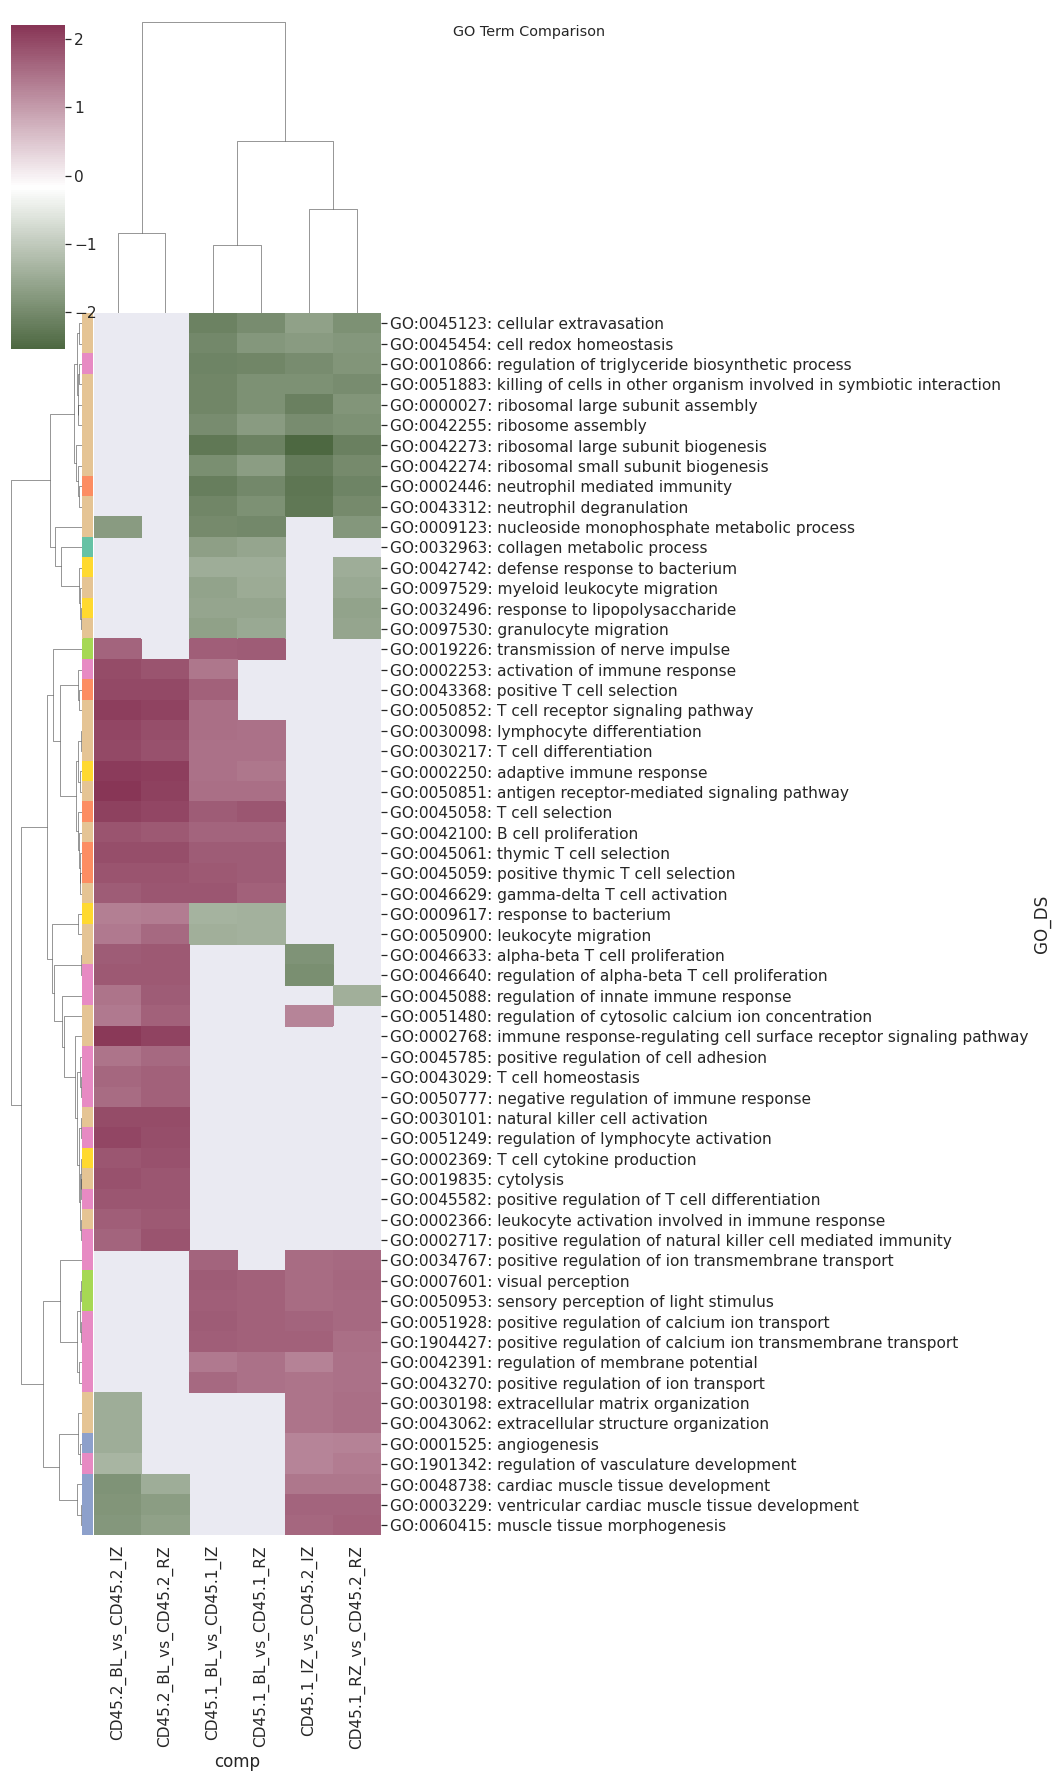

In [31]:
sns.set(font_scale=1.4)
ax = sns.clustermap(plotDF, row_colors=indexColors, row_cluster=True, col_cluster=True, mask=plotDF.to_numpy()== 0, yticklabels=1, cmap=rvb_rev, figsize=(15,25))
sns.set()
plt.suptitle("GO Term Comparison")


plt.gcf().savefig("go_heatmap_bulk_all.pdf", bbox_inches='tight')
plt.gcf().savefig("go_heatmap_bulk_all.png", bbox_inches='tight')
plt.gcf().savefig("go_heatmap_bulk_all.svg", bbox_inches='tight')

plt.show()

In [32]:
conds = ["CD45.1_IZ","CD45.2_IZ","CD45.1_RZ","CD45.2_RZ","CD45.1_BL","CD45.2_BL"]
keepConds_izrz = [("CD45.1_IZ", "CD45.1_RZ"),("CD45.2_IZ", "CD45.2_RZ")]

go2df_goc = {}

for i in range(0, len(conds)):
    for j in range(i+1, len(conds)):
        
        ci = conds[i]
        cj = conds[j]
        
        reportsFile = "../reports_merged/{}_vs_{}/{}_vs_{}.hisat2.DirectDESeq2.tsv.GeneOntology.BP.all.gsea.tsv".format(ci,cj, ci,cj)
        
        godf = pd.read_csv(reportsFile, sep="\t")
        
        if (ci, cj) in keepConds_izrz:
            
            godf["comp"] = "{}_vs_{}".format(ci,cj)
            
        elif (cj, ci) in keepConds_izrz:
            print(ci, cj, "turn")
            #turn around
            godf["comp"] = "{}_vs_{}".format(cj,ci)
            godf["NES"] = -godf.NES
            
        else:
            continue
            
        
        godf = godf[godf.qvalue < 0.1]
        #godf["NES"] = -godf.NES
        
        go2df_goc[(cj, ci)] = godf
        print(ci, cj)
        
        
        
        #print(ci, cj, reportsFile, os.path.exists(reportsFile), go2df[(ci,cj)].shape)

all_go = pd.concat(go2df_goc.values())
all_go["GO_SIZE"] = all_go.core_enrichment.str.split("/").map(len)
all_go['GO_DS'] = all_go[["GO.ID", "Description"]].agg(': '.join, axis=1)

sel_go = all_go.loc[:,['comp', 'GO_DS', 'GO_SIZE', 'NES', 'qvalue']]
sel_go

topGONames = sel_go.GO_DS.value_counts()[:60].index.tolist()

top_go = sel_go[sel_go.GO_DS.isin(topGONames)]

#tiGO =top_go.set_index(["comp", "Description"])
tiGOizrz = top_go.loc[:, ['comp', 'GO_DS', 'NES', 'GO_SIZE']]
tiGOizrz

CD45.1_IZ CD45.1_RZ
CD45.2_IZ CD45.2_RZ


,comp,GO_DS,NES,GO_SIZE
0,CD45.1_IZ_vs_CD45.1_RZ,GO:0001525: angiogenesis,-2.300620,115
1,CD45.1_IZ_vs_CD45.1_RZ,GO:0006364: rRNA processing,-2.518785,92
6,CD45.1_IZ_vs_CD45.1_RZ,GO:0034660: ncRNA metabolic process,-2.164651,183
7,CD45.1_IZ_vs_CD45.1_RZ,GO:0042254: ribosome biogenesis,-2.542802,139
10,CD45.1_IZ_vs_CD45.1_RZ,GO:0045765: regulation of angiogenesis,-2.092469,66
...,...,...,...,...
420,CD45.2_IZ_vs_CD45.2_RZ,GO:0044843: cell cycle G1/S phase transition,-1.472564,40
442,CD45.2_IZ_vs_CD45.2_RZ,GO:0002428: antigen processing and presentatio...,1.646112,13
445,CD45.2_IZ_vs_CD45.2_RZ,GO:1903034: regulation of response to wounding,-1.469900,36
449,CD45.2_IZ_vs_CD45.2_RZ,GO:0071222: cellular response to lipopolysacch...,-1.515570,46


In [33]:
set(tiGOizrz.comp)

{'CD45.1_IZ_vs_CD45.1_RZ', 'CD45.2_IZ_vs_CD45.2_RZ'}

In [36]:
plotDF

comp,CD45.1_IZ_vs_CD45.1_RZ,CD45.2_IZ_vs_CD45.2_RZ
GO_DS,,
GO:0000027: ribosomal large subunit assembly,-2.063408,-2.055990
GO:0001503: ossification,-1.466572,-1.517596
GO:0001525: angiogenesis,-2.300620,-1.870861
GO:0001706: endoderm formation,-2.052695,-1.849790
GO:0001819: positive regulation of cytokine production,-1.399820,-1.579862
GO:0001936: regulation of endothelial cell proliferation,-1.800708,-1.525845
GO:0002040: sprouting angiogenesis,-1.903630,-1.693792
GO:0002043: blood vessel endothelial cell proliferation involved in sprouting angiogenesis,-1.753846,-1.702595
GO:0002237: response to molecule of bacterial origin,-1.522100,-1.536935


In [37]:
plotDF = tiGO[tiGO.comp.isin(["CD45.1_IZ_vs_CD45.2_IZ","CD45.1_RZ_vs_CD45.2_RZ"])]


#plotDF = tiGO[tiGO.comp !="CD45.1_BL_vs_CD45.2_BL"]


plotDF = plotDF.pivot("comp", "GO_DS", "NES").transpose()
plotDF = plotDF.fillna(0)

idxElem2GoInfo = {}

for elem in plotDF.index:
    es = elem.split(":")
    goIdIdx = ":".join(es[:2])
    print(goIdIdx)
    
    gosubdag = GoSubDag(goIdIdx, go, prt=False)
    
    level2info = {}
    for p_go in gosubdag.rcntobj.go2ancestors[goIdIdx]:
        idInfo = gosubdag.go2nt[p_go]._asdict()        
        level2info[idInfo["level"]] = idInfo
        
    goLevel = 1
    if goLevel in level2info:
        useElem = level2info[goLevel]
    else:
        print("no level for", elem, level2info)
        goDesc = elem.split(": ")[1]
        useElem = {'GO': goIdIdx, 'GO_name': goDesc}
    idxElem2GoInfo[goIdIdx] = useElem
    

allParents = set()
for x in idxElem2GoInfo:
    allParents.add(idxElem2GoInfo[x]["GO"])
    
allParents = list(allParents)
allColors = sns.color_palette("Set2", len(allParents))
indexColors = []

for elem in plotDF.index:
    es = elem.split(":")
    goIdIdx = ":".join(es[:2])
    
    colorIdx = allParents.index(idxElem2GoInfo[goIdIdx]["GO"])
    goIdIdxColor = allColors[colorIdx]
    indexColors.append(goIdIdxColor)


GO:0000027
GO:0001525
GO:0002446
GO:0003229
GO:0007601
GO:0009123
GO:0010866
GO:0030198
GO:0032496
GO:0034767
GO:0042255
GO:0042273
GO:0042274
GO:0042391
GO:0042742
GO:0043062
GO:0043270
GO:0043312
GO:0045088
GO:0045123
GO:0045454
GO:0046633
GO:0046640
GO:0048738
GO:0050953
GO:0051480
GO:0051883
GO:0051928
GO:0060415
GO:0097529
GO:0097530
GO:1901342
GO:1904427


In [38]:
plotDF["GO_DS"] = ["{} ({})".format(y,x) for x,y in plotDF.index.str.split(": ")]
plotDF = plotDF.set_index("GO_DS")

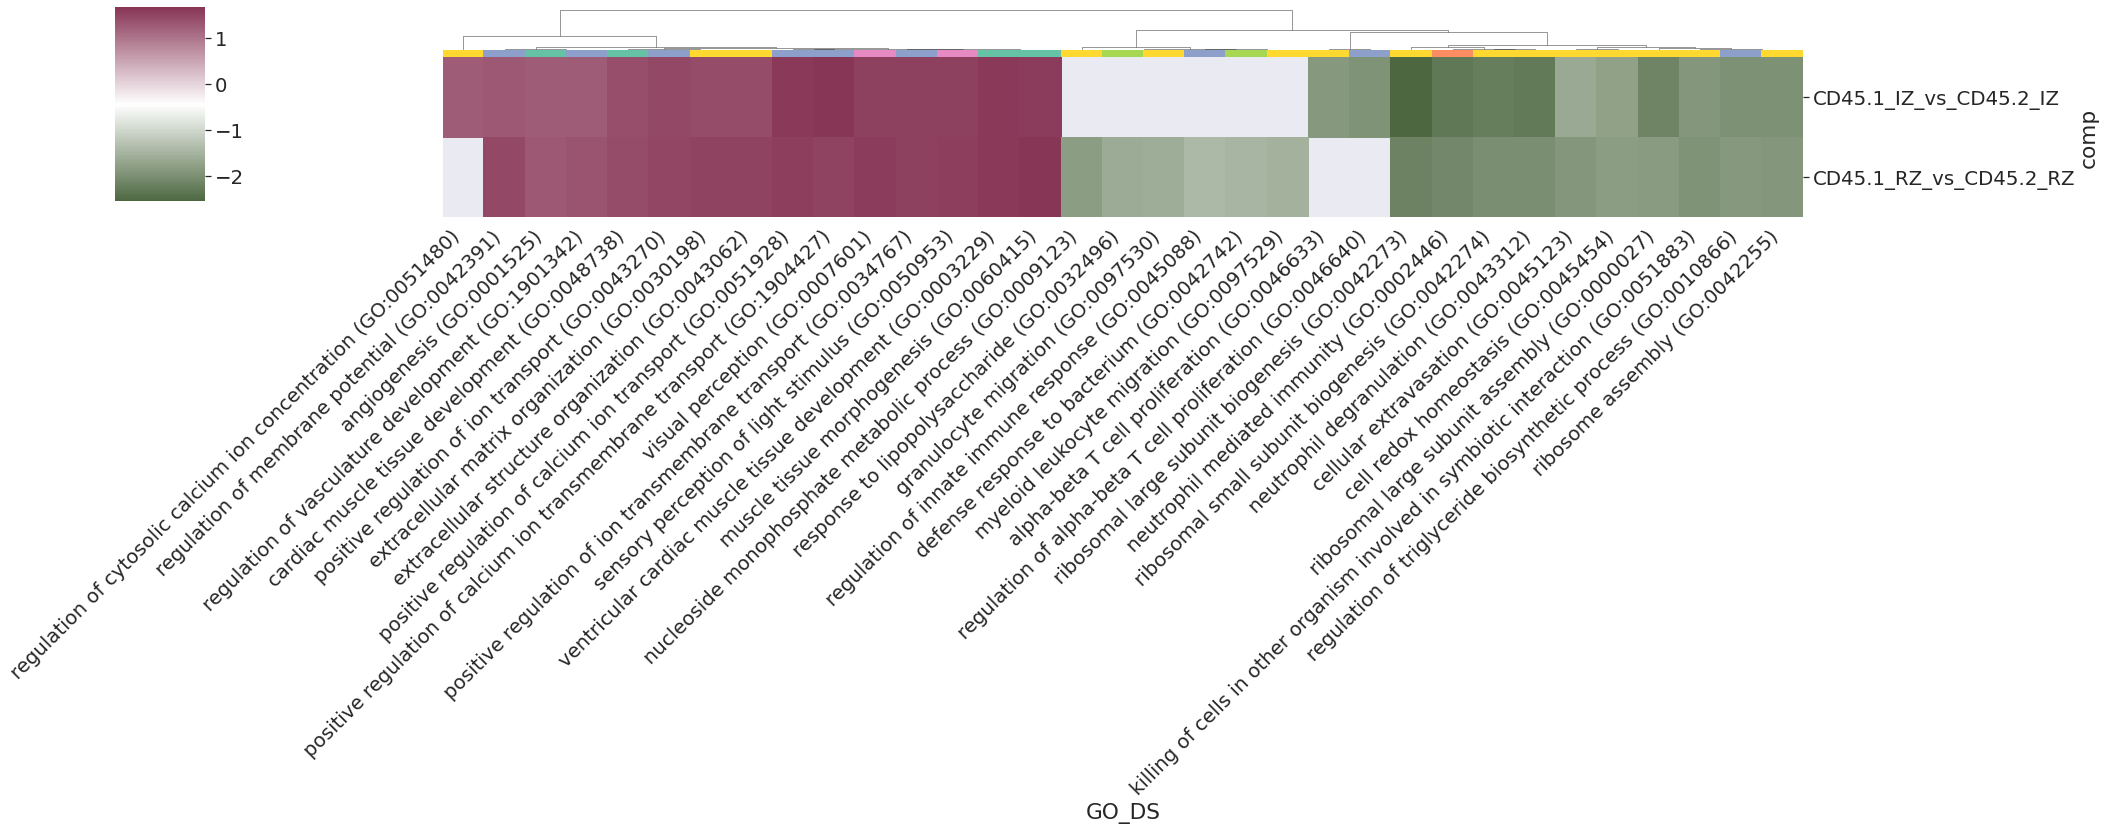

In [51]:
sns.set(font_scale=1.8)
ax = sns.clustermap(plotDF.T, col_colors=indexColors, row_cluster=False, col_cluster=True,
                    mask=plotDF.T.to_numpy()== 0, yticklabels=1, cmap=rvb_rev, figsize=(25,15))
plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=45, ha="right")
sns.set()
#plt.suptitle("GO Term Comparison")


plt.gcf().savefig("go_heatmap_bulk_izrz.pdf", bbox_inches='tight')
plt.gcf().savefig("go_heatmap_bulk_izrz.png", bbox_inches='tight')
plt.gcf().savefig("go_heatmap_bulk_izrz.svg", bbox_inches='tight')

plt.show()

# PCA

In [37]:
samples = []

cond2samples = defaultdict(set)
samples2cond = {}
cond2marker = {}

markerTypes = ["D", "o", "^", "s", "<", ">", "1", "p", "P", "*", "H", "X", "x", "d"]

In [38]:
ls ../counts_merged/

convert_counts.py*           trim.hisat2.prim.O.5.counts.summary
orig/                        trim.star.prim.O.5.counts
origtomerged.tsv*            trim.star.prim.O.5.counts.summary
trim.hisat2.prim.O.5.counts


In [39]:
countDF = pd.read_csv("../counts_merged/trim.hisat2.prim.O.5.counts", skipinitialspace=True, sep='\t', comment='#')
print(countDF.columns)

Index(['Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'CD45.2_BL_1_S1',
       'CD45.1_BL_1_S2', 'CD45.1_BL_2_S3', 'CD45.2_BL_2_S4', 'CD45.2_BL_3_S5',
       'CD45.1_BL_3_S6', 'CD45.1_BL_4_S7', 'CD45.2_BL_4_S8', 'CD45.1_RZ_S104',
       'CD45.1_IZ_S105', 'CD45.2_RZ_S106', 'CD45.2_IZ_S107', 'CD45.1_RZ_S108',
       'CD45.1_IZ_S109', 'CD45.2_RZ_S110', 'CD45.2_IZ_S111', 'CD45.1_RZ_S112',
       'CD45.1_IZ_S113', 'CD45.2_RZ_S114', 'CD45.2_IZ_S115'],
      dtype='object')


In [40]:
all_samples = [x for x in countDF.columns if x.startswith("CD45")]
all_samples

['CD45.2_BL_1_S1',
 'CD45.1_BL_1_S2',
 'CD45.1_BL_2_S3',
 'CD45.2_BL_2_S4',
 'CD45.2_BL_3_S5',
 'CD45.1_BL_3_S6',
 'CD45.1_BL_4_S7',
 'CD45.2_BL_4_S8',
 'CD45.1_RZ_S104',
 'CD45.1_IZ_S105',
 'CD45.2_RZ_S106',
 'CD45.2_IZ_S107',
 'CD45.1_RZ_S108',
 'CD45.1_IZ_S109',
 'CD45.2_RZ_S110',
 'CD45.2_IZ_S111',
 'CD45.1_RZ_S112',
 'CD45.1_IZ_S113',
 'CD45.2_RZ_S114',
 'CD45.2_IZ_S115']

In [41]:
cond2samples = defaultdict(list)

for x in all_samples:
    cond = "_".join(x.split("_")[0:2])
    
    cond2samples[cond].append(x)
    
for x in cond2samples:
    print(x, cond2samples[x])

CD45.2_BL ['CD45.2_BL_1_S1', 'CD45.2_BL_2_S4', 'CD45.2_BL_3_S5', 'CD45.2_BL_4_S8']
CD45.1_BL ['CD45.1_BL_1_S2', 'CD45.1_BL_2_S3', 'CD45.1_BL_3_S6', 'CD45.1_BL_4_S7']
CD45.1_RZ ['CD45.1_RZ_S104', 'CD45.1_RZ_S108', 'CD45.1_RZ_S112']
CD45.1_IZ ['CD45.1_IZ_S105', 'CD45.1_IZ_S109', 'CD45.1_IZ_S113']
CD45.2_RZ ['CD45.2_RZ_S106', 'CD45.2_RZ_S110', 'CD45.2_RZ_S114']
CD45.2_IZ ['CD45.2_IZ_S107', 'CD45.2_IZ_S111', 'CD45.2_IZ_S115']


In [42]:
cond2color = {
    "CD45.1_BL": color2,
    "CD45.2_BL": color1,
    "CD45.1_IZ": color2_nosig,
    "CD45.2_IZ": color1_nosig,
    "CD45.1_RZ": color2_nosig_less,
    "CD45.2_RZ": color1_nosig_less,
}

In [43]:
cond2color

{'CD45.1_BL': '#4d6841',
 'CD45.2_BL': '#883656',
 'CD45.1_IZ': '#70975E',
 'CD45.2_IZ': '#BA507A',
 'CD45.1_RZ': '#99b78b',
 'CD45.2_RZ': '#d087a4'}

In [44]:
countDF.set_index("Geneid", inplace=True)

In [45]:
scntDF = countDF[all_samples]
scntDF

,CD45.2_BL_1_S1,CD45.1_BL_1_S2,CD45.1_BL_2_S3,CD45.2_BL_2_S4,CD45.2_BL_3_S5,CD45.1_BL_3_S6,CD45.1_BL_4_S7,CD45.2_BL_4_S8,CD45.1_RZ_S104,CD45.1_IZ_S105,CD45.2_RZ_S106,CD45.2_IZ_S107,CD45.1_RZ_S108,CD45.1_IZ_S109,CD45.2_RZ_S110,CD45.2_IZ_S111,CD45.1_RZ_S112,CD45.1_IZ_S113,CD45.2_RZ_S114,CD45.2_IZ_S115
Geneid,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951,0,0,0,0,0,0,0,0,0,0,16,0,0,0,4,9,0,0,0,8
ENSMUSG00000102851,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000094431,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
ENSMUSG00000094621,30,0,0,5,80,1,0,81,0,0,2,4,0,0,1,1,0,0,0,1
ENSMUSG00000098647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
libSizeFactor = int(np.log10(max(scntDF.sum())))+1

scaleFactor = 1#10 ** libSizeFactor
scntDF = (scntDF / scntDF.sum()) * scaleFactor

In [47]:
scntDF

,CD45.2_BL_1_S1,CD45.1_BL_1_S2,CD45.1_BL_2_S3,CD45.2_BL_2_S4,CD45.2_BL_3_S5,CD45.1_BL_3_S6,CD45.1_BL_4_S7,CD45.2_BL_4_S8,CD45.1_RZ_S104,CD45.1_IZ_S105,CD45.2_RZ_S106,CD45.2_IZ_S107,CD45.1_RZ_S108,CD45.1_IZ_S109,CD45.2_RZ_S110,CD45.2_IZ_S111,CD45.1_RZ_S112,CD45.1_IZ_S113,CD45.2_RZ_S114,CD45.2_IZ_S115
Geneid,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
ENSMUSG00000064842,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
ENSMUSG00000051951,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.077772e-07,0.000000e+00,0.000000,0.000000,8.536829e-08,2.706495e-07,0.000000,0.000000,0.000000,1.495684e-07
ENSMUSG00000102851,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
ENSMUSG00000103377,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000094431,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.923608e-08,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
ENSMUSG00000094621,9.347863e-07,0.000000,0.000000,1.409145e-07,0.000003,4.084427e-08,0.000000,0.000003,0.000000,0.000000,3.847215e-08,7.678378e-08,0.000000,0.000000,2.134207e-08,3.007217e-08,0.000000,0.000000,0.000000,1.869605e-08
ENSMUSG00000098647,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00


In [48]:
tsneDF = scntDF.nlargest(1000, all_samples).transpose()
print(tsneDF.shape)

mrmrDF = tsneDF.copy()
mrmrDF.insert(loc = 0, 
          column = 'target', 
          value = mrmrDF.index.str[0:9])
mrmrDF.set_index("target", inplace=True)
mrmrDF

(20, 1000)


Geneid,ENSMUSG00000069516,ENSMUSG00000002985,ENSMUSG00000050708,ENSMUSG00000024610,ENSMUSG00000092341,ENSMUSG00000110350,ENSMUSG00000076036,ENSMUSG00000021939,ENSMUSG00000029580,ENSMUSG00000073411,...,ENSMUSG00000049517,ENSMUSG00000022139,ENSMUSG00000031708,ENSMUSG00000072235,ENSMUSG00000022575,ENSMUSG00000037936,ENSMUSG00000040904,ENSMUSG00000040964,ENSMUSG00000024949,ENSMUSG00000002981
target,,,,,,,,,,,,,,,,,,,,,
CD45.2_BL,0.019414,0.017373,0.012378,0.007399,0.005986,0.005917,0.005287,0.005272,0.005216,0.005190,...,0.000166,0.000166,0.000166,0.000166,0.000166,0.000166,0.000165,0.000165,0.000165,0.000165
CD45.1_BL,0.013799,0.022243,0.010295,0.019365,0.003415,0.004895,0.004189,0.005848,0.007175,0.003842,...,0.000073,0.000191,0.000105,0.000121,0.000108,0.000059,0.000115,0.000117,0.000148,0.000221
CD45.1_BL,0.017918,0.022800,0.008861,0.017342,0.003257,0.004092,0.003713,0.006134,0.004621,0.004293,...,0.000073,0.000188,0.000108,0.000096,0.000108,0.000059,0.000127,0.000111,0.000137,0.000216
CD45.2_BL,0.020527,0.013264,0.008971,0.007750,0.004104,0.003515,0.003670,0.006306,0.005895,0.004830,...,0.000090,0.000206,0.000119,0.000086,0.000138,0.000133,0.000165,0.000157,0.000162,0.000215
CD45.2_BL,0.015740,0.006105,0.006335,0.017288,0.004547,0.003040,0.002508,0.002990,0.003851,0.005912,...,0.000131,0.000172,0.000124,0.000103,0.000209,0.000145,0.000109,0.000113,0.000175,0.000172
CD45.1_BL,0.016999,0.023560,0.011326,0.026332,0.003885,0.005344,0.004622,0.005867,0.003345,0.004601,...,0.000084,0.000142,0.000111,0.000112,0.000114,0.000041,0.000130,0.000121,0.000134,0.000199
CD45.1_BL,0.015845,0.021057,0.010364,0.019676,0.003505,0.005091,0.004277,0.005498,0.003771,0.004370,...,0.000072,0.000134,0.000124,0.000116,0.000117,0.000055,0.000110,0.000119,0.000146,0.000207
CD45.2_BL,0.015711,0.011205,0.009633,0.011053,0.005599,0.004385,0.003906,0.005166,0.003228,0.006207,...,0.000118,0.000178,0.000122,0.000176,0.000165,0.000123,0.000149,0.000173,0.000167,0.000196
CD45.1_RZ,0.014732,0.006409,0.016238,0.000894,0.001476,0.008041,0.006427,0.011126,0.011001,0.002323,...,0.000118,0.000181,0.000090,0.000132,0.000110,0.000108,0.000139,0.000124,0.000175,0.000261


In [49]:
bgenes = pymrmr.mRMR(mrmrDF, 'MIQ', 100)

In [50]:
tsneSelGenesDF = tsneDF[bgenes]

In [51]:
X_embedded = umap.UMAP(n_neighbors=3).fit_transform(tsneSelGenesDF.values)

In [52]:
sample2index = {}
for i in range(0, len(tsneSelGenesDF.index)):
    sample2index[tsneSelGenesDF.index[i]] = i

In [53]:
cond2samples

defaultdict(list,
            {'CD45.2_BL': ['CD45.2_BL_1_S1',
              'CD45.2_BL_2_S4',
              'CD45.2_BL_3_S5',
              'CD45.2_BL_4_S8'],
             'CD45.1_BL': ['CD45.1_BL_1_S2',
              'CD45.1_BL_2_S3',
              'CD45.1_BL_3_S6',
              'CD45.1_BL_4_S7'],
             'CD45.1_RZ': ['CD45.1_RZ_S104',
              'CD45.1_RZ_S108',
              'CD45.1_RZ_S112'],
             'CD45.1_IZ': ['CD45.1_IZ_S105',
              'CD45.1_IZ_S109',
              'CD45.1_IZ_S113'],
             'CD45.2_RZ': ['CD45.2_RZ_S106',
              'CD45.2_RZ_S110',
              'CD45.2_RZ_S114'],
             'CD45.2_IZ': ['CD45.2_IZ_S107',
              'CD45.2_IZ_S111',
              'CD45.2_IZ_S115']})

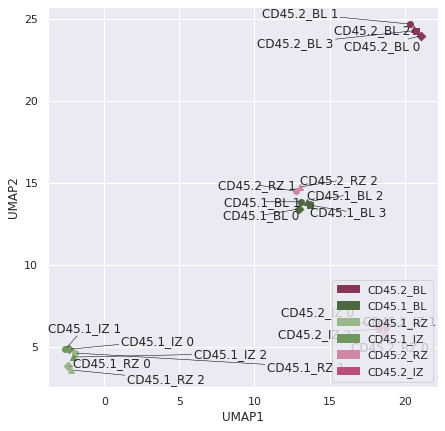

In [54]:
plt.figure(figsize=(7,7))
texts = []
patches = []

for ci, cond in enumerate(cond2samples):
    
    embx = []
    emby = []
    samples = []
    embmt = []
    embc = []
    
    for si,sample in enumerate(cond2samples[cond]):
        
        xpos = X_embedded[sample2index[sample], 0]
        ypos = X_embedded[sample2index[sample], 1]
        
        sampleName = sample[:9] + " " + str(si)
        
        embx.append(xpos)
        emby.append(ypos)
        samples.append(sample)
        
        embmt.append(markerTypes[si])
        embc.append(cond2color[cond])
        
        texts.append(plt.text(xpos, ypos, sampleName))
        
        
    for x,y,m,c in zip(embx, emby, embmt, embc):
        plt.scatter(x, y, marker=m, color=c)
        
    cond_patch = mpatches.Patch(color=cond2color[cond], label=cond)
    patches.append(cond_patch)


adjust_text(texts, force_points=0.2, force_text=0.5,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

legend = plt.gca().legend(handles=patches,loc='lower right')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

plt.savefig("umap_hisat2_prim.png", bbox_inches="tight")
plt.savefig("umap_hisat2_prim.pdf", bbox_inches="tight")
plt.savefig("umap_hisat2_prim.svg", bbox_inches="tight")

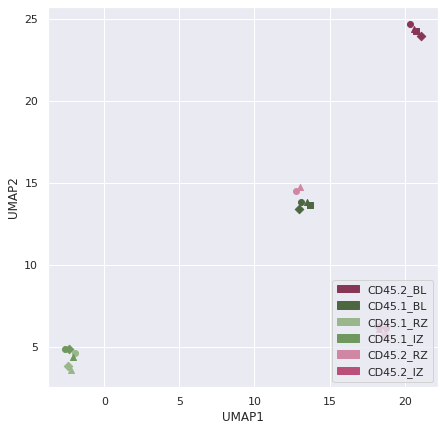

In [55]:
plt.figure(figsize=(7,7))
texts = []
patches = []

for ci, cond in enumerate(cond2samples):
    
    embx = []
    emby = []
    samples = []
    embmt = []
    embc = []
    
    for si,sample in enumerate(cond2samples[cond]):
        
        xpos = X_embedded[sample2index[sample], 0]
        ypos = X_embedded[sample2index[sample], 1]
        
        sampleName = sample[:9] + " " + str(si)
        
        embx.append(xpos)
        emby.append(ypos)
        samples.append(sample)
        
        embmt.append(markerTypes[si])
        embc.append(cond2color[cond])
        
        
        
    for x,y,m,c in zip(embx, emby, embmt, embc):
        plt.scatter(x, y, marker=m, color=c)
        
    cond_patch = mpatches.Patch(color=cond2color[cond], label=cond)
    patches.append(cond_patch)


legend = plt.gca().legend(handles=patches,loc='lower right')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

plt.savefig("umap_hisat2_prim_nolabel.png", bbox_inches="tight")
plt.savefig("umap_hisat2_prim_nolabel.pdf", bbox_inches="tight")
plt.savefig("umap_hisat2_prim_nolabel.svg", bbox_inches="tight")

In [56]:
X_embedded_pca = sklearn.decomposition.PCA().fit_transform(tsneSelGenesDF.values)

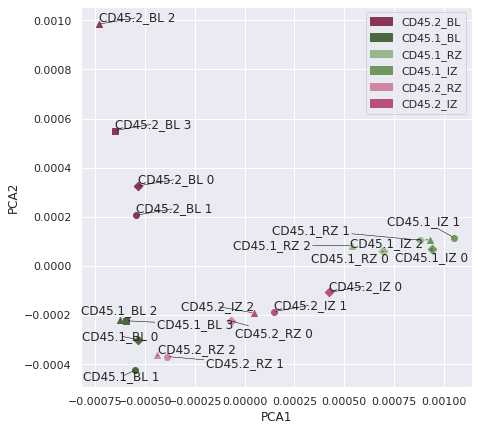

In [57]:
plt.figure(figsize=(7,7))
texts = []

patches = []

for ci, cond in enumerate(cond2samples):
    
    embx = []
    emby = []
    samples = []
    embmt = []
    embc = []
    
    for si,sample in enumerate(cond2samples[cond]):
        
        xpos = X_embedded_pca[sample2index[sample], 0]
        ypos = X_embedded_pca[sample2index[sample], 1]
        
        sampleName = sample[:9] + " " + str(si)
        
        embx.append(xpos)
        emby.append(ypos)
        samples.append(sample)
        
        embmt.append(markerTypes[si])
        embc.append(cond2color[cond])
        
        texts.append(plt.text(xpos, ypos, sampleName))
        
    cond_patch = mpatches.Patch(color=cond2color[cond], label=cond)
    patches.append(cond_patch)
        
    for x,y,m,c in zip(embx, emby, embmt, embc):
        plt.scatter(x, y, marker=m, color=c)
    
adjust_text(texts, force_points=0.2, force_text=0.5,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# define and place the legend
legend = plt.gca().legend(handles=patches,loc='upper right')

plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.savefig("pca_hisat2_prim.png", bbox_inches="tight")
plt.savefig("pca_hisat2_prim.pdf", bbox_inches="tight")
plt.savefig("pca_hisat2_prim.svg", bbox_inches="tight")

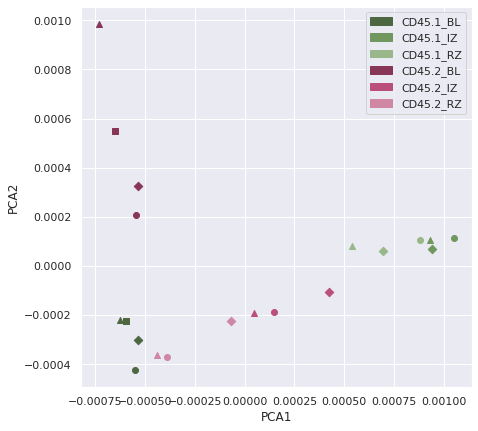

In [58]:
plt.figure(figsize=(7,7))
texts = []

patches = []

for ci, cond in enumerate(natsorted(cond2samples)):
    
    embx = []
    emby = []
    samples = []
    embmt = []
    embc = []
    
    for si,sample in enumerate(cond2samples[cond]):
        
        xpos = X_embedded_pca[sample2index[sample], 0]
        ypos = X_embedded_pca[sample2index[sample], 1]
        
        sampleName = sample[:9] + " " + str(si)
        
        embx.append(xpos)
        emby.append(ypos)
        samples.append(sample)
        
        embmt.append(markerTypes[si])
        embc.append(cond2color[cond])
        
        
    cond_patch = mpatches.Patch(color=cond2color[cond], label=cond)
    patches.append(cond_patch)
        
    for x,y,m,c in zip(embx, emby, embmt, embc):
        plt.scatter(x, y, marker=m, color=c)
    
# define and place the legend
legend = plt.gca().legend(handles=patches,loc='upper right')

plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.savefig("pca_hisat2_prim_nolabel.png", bbox_inches="tight")
plt.savefig("pca_hisat2_prim_nolabel.pdf", bbox_inches="tight")
plt.savefig("pca_hisat2_prim_nolabel.svg", bbox_inches="tight")